In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score,auc
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import RandomOverSampler
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeRandomOverSamples(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original training set shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    ros = RandomOverSampler(random_state=123)
    X_train, Y_train_labelled = ros.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [4]:
image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


# Evaluation: Utility Functions

In [7]:
# onehot encoded Y_all
def kFold_train(X_all,Y_all, mode_version):
    from sklearn.model_selection import StratifiedKFold
    n_split=10
    n_classes=8

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]

    count = 1

    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
        x_train,x_test=X_all[train_index],X_all[test_index]
        y_train,y_test=Y_all[train_index],Y_all[test_index]
        
        
       
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
        x_train, y_train= makeRandomOverSamples(x_train, y_train)

        # create and fit the model
        cv_model=build_current_model() # lr,dense,cnn
        history = cv_model.fit(x_train, y_train,
                  batch_size=8,
                  epochs=100,
                  validation_data= (x_val, y_val),
                  verbose=2,
                  callbacks=my_callbacks)


        file_name = mode_version +'_iter_' +str(count)
        
        
                
        #store test index
        csv_name= mode_version +'_testset_iter_' +str(count)
        test_index_df = pd.DataFrame(data=test_index,columns=["test_index"])
        with open(csv_name, mode='w') as f:
                 test_index_df.to_csv(f)
        #Store History
        hist_df = pd.DataFrame(history.history) 
        hist_json_file = file_name + '.json'

        with open(hist_json_file, mode='w') as f:
            hist_df.to_json(f)
            
            

        model_file = file_name + '.model'
        print(model_file)

        #Save Model
        cv_model.save(model_file) #Save the model

        count+=1

In [8]:
def kFold_test(X_all,Y_all, mode_version):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
    from sklearn.metrics import confusion_matrix

    n_split=10
    n_classes=8

    all_base_precision = list()
    all_base_recall = list()
    all_macro_precision = list()
    all_macro_recall = list()
    all_f1 = list()
    all_macro_f1 = list()

    all_tpr = list()
    all_fpr = list()
    all_precision = list()
    all_recall = list()
    all_cm=list()
    all_accuracy = list()

    all_df = list()

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    count = 1


    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
#         x_train,_=X_all[train_index],X_all[test_index]
#         y_train,y_test=Y_all[train_index],Y_all[test_index]


        file_name = mode_version +'_iter_' +str(count)
        csv_name= mode_version +'_testset_iter_' +str(count)
        #Load History 
        hist_json_file = file_name + '.json'
        history_info = pd.read_json(hist_json_file)
        all_df.append(history_info)


        # Load Model
        model_file = file_name + '.model'
        print('File Name Loaded: ',model_file)
        cv_model = tf.keras.models.load_model(model_file) 
        
        #load test set 
        testset_file= csv_name
        testset_df= pd.read_csv (testset_file)
        test_index=testset_df["test_index"].to_numpy()
       
        x_test=X_all[test_index]
        y_test=Y_all[test_index]


        count+=1

        #generate predictions
        y_pred = cv_model.predict(x_test)
        actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)

        #calc metrics
        curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
        curr_macro_prec = precision_score(actual, predicted,average='macro')
        curr_macro_rec = recall_score(actual, predicted,average='macro')
        curr_macro_f1 = f1_score(actual, predicted,average='macro')

        actual_labeled = list()
        predict_labeled = list()
        for x,y in zip(actual,predicted):
            actual_labeled.append(getSpecies(x))
            predict_labeled.append(getSpecies(y))

        labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)

        curr_fpr = [0] * n_classes
        curr_tpr = [0] * n_classes
        for i in range(n_classes):
            curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])

        curr_prec = [0] * n_classes
        curr_rec = [0] * n_classes
        for i in range(n_classes):
            curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])


        curr_accuracy = accuracy_score(actual, predicted)

        #add to lists
        all_base_precision.append(curr_base_prec)
        all_base_recall.append(curr_base_rec)
        all_macro_precision.append(curr_macro_prec)
        all_macro_recall.append(curr_macro_rec)

        all_f1.append(curr_f1)
        all_macro_f1.append(curr_macro_f1)

        all_accuracy.append(curr_accuracy)


        all_fpr.append(curr_fpr)
        all_tpr.append(curr_tpr)
        all_precision.append(curr_prec)
        all_recall.append(curr_rec)
        all_cm.append(curr_cm)
    kFold_metrics={
            "all_base_precision": all_base_precision ,
            "all_base_recall": all_base_recall,
            "all_macro_precision":all_macro_precision ,
            "all_macro_recall":all_macro_recall ,
            "all_f1":all_f1,
            "all_macro_f1":all_macro_f1 ,
        
            "all_accuracy":all_accuracy ,
            "all_fpr":all_fpr,
            "all_tpr": all_tpr,
            "all_precision":all_precision,
            "all_recall":all_recall,
            "all_cm": all_cm,
            "all_df":all_df
            
        }
    return kFold_metrics




In [9]:
def plot_loss_Accuracy(all_df):
    for df in all_df:
        _, axs = plt.subplots(ncols=2)

        sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
        sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

        sns.lineplot(data=df['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
        sns.lineplot(data=df['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [10]:
def print_metrics(KFold_metrics):
    print('precision mean by class', np.array(KFold_metrics.get("all_base_precision")).mean(axis=0))
    print('precision sdev by class', np.array(KFold_metrics.get("all_base_precision")).std(axis=0))

    print('macro precision mean', np.array(KFold_metrics.get("all_macro_precision")).mean())
    print('macro precision sdev', np.array(KFold_metrics.get("all_macro_precision")).std())


    print('recall mean', np.array(KFold_metrics.get("all_base_recall")).mean(axis=0))
    print('recall sdev', np.array(KFold_metrics.get("all_base_recall")).std(axis=0))

    print('macro recall mean', np.array(KFold_metrics.get("all_macro_recall")).mean())
    print('macro recall sdev', np.array(KFold_metrics.get("all_macro_recall")).std())

    print('f1 mean', np.array(KFold_metrics.get("all_f1")).mean(axis=0))
    print('f1 sdev', np.array(KFold_metrics.get("all_f1")).std(axis=0))

    print('macro f1 mean', np.array(KFold_metrics.get("all_macro_f1")).mean())
    print('macro f1 sdev', np.array(KFold_metrics.get("all_macro_f1")).std())

    print('accuracy mean', np.array(KFold_metrics.get("all_accuracy")).mean())
    print('accuracy sdev', np.array(KFold_metrics.get("all_accuracy")).std())



In [11]:
# Plot all K-Fold ROC curves
def plot_ROC(all_fpr,all_tpr,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            auc_val = np.around(auc_val,4)
            sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')


In [12]:
def print_meanAUC(all_fpr,all_tpr,n_split=10, n_classes=8):
    aucs = list()

    for i in range(n_classes):
        aucs.append(list())


    for i in range(n_split):
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            aucs[j].append(auc_val)

    for i in range(n_classes):
        print("Sp: ", getSpecies(i))
        print("AUC Mean ", np.array(aucs[i]).mean())
        print("Std ", np.array(aucs[i]).std())

In [13]:
#Plot all K-Fold Precision/Recall curves
def plot_precision_recall(all_recall,all_precision,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

In [14]:
def plot_confusion_matrices_per_iter(all_cm,n_split=10, n_classes=8):
    ## Plot all K-Fold confusion matrices
    import numpy as np
    import matplotlib.pylab as pl
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    # Create 1X 5 sub plots
    # gs = gridspec.GridSpec(1,n_split)
    figs=[]
    for i in range(n_split):
        figs.append(plt.figure())

    for i in range(n_split):
        print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
        print(all_cm[i])
        print("\n")

        ax=figs[i].add_subplot()
        sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells


        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
        ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [15]:
def  plot_macro_confusion_matrices(all_cm,n_split=10, n_classes=8):
    ## plot macro cm
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
    for i in range(n_split):
        sum_all_cm+=all_cm[i]


    #plot 
    figs=[]
    for i in range(2):
        figs.append(plt.figure())

    print("sum of all confuion matrices\n",sum_all_cm)
    ax=figs[0].add_subplot()
    sns.heatmap(sum_all_cm, annot=True, ax = ax);

    avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
    print("\naverage of all confuion matrices\n",avg_all_cm)
    ax=figs[1].add_subplot()
    sns.heatmap(avg_all_cm, annot=True, ax = ax);
    return sum_all_cm, avg_all_cm

In [16]:
 def plot_normalised_confusion_matrix( sum_all_cm, avg_all_cm, n_split=10, n_classes=8):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        

    cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
    cm = (np.around(cm,2))
    print(cm)


    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

### Load and Evaluate



## V1 !!!!! K-Fold Training and Evaluation


In [47]:
folder = "models"
mode_version = "mel_RO_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_RO_v1


In [48]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [61]:
model = build_current_model()
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_110 (Bat (None, 56, 85, 56)        224       
_________________________________________________________________
activation_110 (Activation)  (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 14, 22, 72)        100

In [50]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 13s - loss: 1.5235 - acc: 0.4249 - val_loss: 0.8162 - val_acc: 0.6875
Epoch 2/100
9592/9592 - 12s - loss: 0.8613 - acc: 0.6854 - val_loss: 0.5511 - val_acc: 0.7941
Epoch 3/100
9592/9592 - 11s - loss: 0.4959 - acc: 0.8316 - val_loss: 0.3702 - val_acc: 0.8824
Epoch 4/100
9592/9592 - 13s - loss: 0.3462 - acc: 0.8866 - val_loss: 0.3085 - val_acc: 0.9099
Epoch 5/100
9592/9592 - 13s - loss: 0.2799 - acc: 0.9090 - val_loss: 0.1887 - val_acc: 0.9

Epoch 19/100
9592/9592 - 11s - loss: 0.1046 - acc: 0.9675 - val_loss: 0.2042 - val_acc: 0.9522
Epoch 20/100
9592/9592 - 11s - loss: 0.0799 - acc: 0.9768 - val_loss: 0.1201 - val_acc: 0.9688
Epoch 21/100
9592/9592 - 11s - loss: 0.0785 - acc: 0.9744 - val_loss: 0.2041 - val_acc: 0.9467
Epoch 22/100
9592/9592 - 11s - loss: 0.0711 - acc: 0.9774 - val_loss: 0.1525 - val_acc: 0.9632
Epoch 23/100
9592/9592 - 12s - loss: 0.0715 - acc: 0.9771 - val_loss: 0.0982 - val_acc: 0.9743
Epoch 24/100
9592/9592 - 11s - loss: 0.0678 - acc: 0.9783 - val_loss: 0.1156 - val_acc: 0.9706
Epoch 25/100
9592/9592 - 11s - loss: 0.0673 - acc: 0.9803 - val_loss: 0.0874 - val_acc: 0.9816
Epoch 26/100
9592/9592 - 12s - loss: 0.0624 - acc: 0.9798 - val_loss: 0.1587 - val_acc: 0.9651
Epoch 27/100
9592/9592 - 12s - loss: 0.0697 - acc: 0.9781 - val_loss: 0.1315 - val_acc: 0.9706
Epoch 28/100
9592/9592 - 11s - loss: 0.0646 - acc: 0.9789 - val_loss: 0.1816 - val_acc: 0.9596
Epoch 29/100
9592/9592 - 11s - loss: 0.0643 - acc:

Epoch 54/100
9592/9592 - 13s - loss: 0.0360 - acc: 0.9879 - val_loss: 0.1458 - val_acc: 0.9669
Epoch 55/100
9592/9592 - 13s - loss: 0.0337 - acc: 0.9910 - val_loss: 0.0749 - val_acc: 0.9835
Epoch 56/100
9592/9592 - 13s - loss: 0.0370 - acc: 0.9888 - val_loss: 0.1297 - val_acc: 0.9779
Epoch 57/100
9592/9592 - 12s - loss: 0.0291 - acc: 0.9901 - val_loss: 0.1262 - val_acc: 0.9761
Epoch 58/100
9592/9592 - 13s - loss: 0.0337 - acc: 0.9903 - val_loss: 0.1420 - val_acc: 0.9779
Epoch 59/100
9592/9592 - 13s - loss: 0.0344 - acc: 0.9888 - val_loss: 0.1152 - val_acc: 0.9724
Epoch 60/100
9592/9592 - 14s - loss: 0.0398 - acc: 0.9860 - val_loss: 0.1458 - val_acc: 0.9779
Epoch 61/100
Restoring model weights from the end of the best epoch.
9592/9592 - 14s - loss: 0.0370 - acc: 0.9879 - val_loss: 0.0832 - val_acc: 0.9743
Epoch 00061: early stopping
models/mel_RO_v1_iter_3.model
Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli'

Epoch 23/100
9584/9584 - 12s - loss: 0.0756 - acc: 0.9759 - val_loss: 0.2005 - val_acc: 0.9669
Epoch 24/100
9584/9584 - 11s - loss: 0.0684 - acc: 0.9801 - val_loss: 0.2582 - val_acc: 0.9559
Epoch 25/100
9584/9584 - 10s - loss: 0.0647 - acc: 0.9790 - val_loss: 0.2256 - val_acc: 0.9688
Epoch 26/100
9584/9584 - 10s - loss: 0.0661 - acc: 0.9782 - val_loss: 0.1468 - val_acc: 0.9688
Epoch 27/100
9584/9584 - 10s - loss: 0.0642 - acc: 0.9794 - val_loss: 0.1936 - val_acc: 0.9614
Epoch 28/100
9584/9584 - 11s - loss: 0.0630 - acc: 0.9788 - val_loss: 0.1740 - val_acc: 0.9632
Epoch 29/100
9584/9584 - 11s - loss: 0.0556 - acc: 0.9835 - val_loss: 0.1336 - val_acc: 0.9706
Epoch 30/100
9584/9584 - 11s - loss: 0.0545 - acc: 0.9829 - val_loss: 0.4388 - val_acc: 0.9228
Epoch 31/100
9584/9584 - 10s - loss: 0.0652 - acc: 0.9793 - val_loss: 0.1533 - val_acc: 0.9688
Epoch 32/100
9584/9584 - 12s - loss: 0.0615 - acc: 0.9824 - val_loss: 0.2184 - val_acc: 0.9688
Epoch 33/100
9584/9584 - 11s - loss: 0.0474 - acc:

Epoch 43/100
9584/9584 - 10s - loss: 0.0463 - acc: 0.9872 - val_loss: 0.1622 - val_acc: 0.9596
Epoch 44/100
9584/9584 - 10s - loss: 0.0474 - acc: 0.9871 - val_loss: 0.2289 - val_acc: 0.9577
Epoch 45/100
9584/9584 - 10s - loss: 0.0477 - acc: 0.9860 - val_loss: 0.1210 - val_acc: 0.9724
Epoch 46/100
9584/9584 - 11s - loss: 0.0412 - acc: 0.9867 - val_loss: 0.1924 - val_acc: 0.9596
Epoch 47/100
9584/9584 - 11s - loss: 0.0407 - acc: 0.9884 - val_loss: 0.1768 - val_acc: 0.9651
Epoch 48/100
9584/9584 - 11s - loss: 0.0424 - acc: 0.9876 - val_loss: 0.1474 - val_acc: 0.9688
Epoch 49/100
9584/9584 - 10s - loss: 0.0420 - acc: 0.9871 - val_loss: 0.1515 - val_acc: 0.9724
Epoch 50/100
9584/9584 - 10s - loss: 0.0390 - acc: 0.9885 - val_loss: 0.1308 - val_acc: 0.9724
Epoch 51/100
9584/9584 - 10s - loss: 0.0397 - acc: 0.9872 - val_loss: 0.1311 - val_acc: 0.9651
Epoch 52/100
9584/9584 - 10s - loss: 0.0417 - acc: 0.9870 - val_loss: 0.1297 - val_acc: 0.9724
Epoch 53/100
9584/9584 - 12s - loss: 0.0376 - acc:

Epoch 23/100
9592/9592 - 14s - loss: 0.0671 - acc: 0.9788 - val_loss: 0.1293 - val_acc: 0.9743
Epoch 24/100
9592/9592 - 14s - loss: 0.0698 - acc: 0.9805 - val_loss: 0.1375 - val_acc: 0.9688
Epoch 25/100
9592/9592 - 13s - loss: 0.0662 - acc: 0.9771 - val_loss: 0.1539 - val_acc: 0.9632
Epoch 26/100
9592/9592 - 13s - loss: 0.0672 - acc: 0.9795 - val_loss: 0.1718 - val_acc: 0.9632
Epoch 27/100
9592/9592 - 13s - loss: 0.0684 - acc: 0.9800 - val_loss: 0.1354 - val_acc: 0.9651
Epoch 28/100
9592/9592 - 13s - loss: 0.0572 - acc: 0.9827 - val_loss: 0.1587 - val_acc: 0.9688
Epoch 29/100
9592/9592 - 12s - loss: 0.0601 - acc: 0.9817 - val_loss: 0.1200 - val_acc: 0.9743
Epoch 30/100
9592/9592 - 12s - loss: 0.0650 - acc: 0.9802 - val_loss: 0.1349 - val_acc: 0.9724
Epoch 31/100
9592/9592 - 14s - loss: 0.0620 - acc: 0.9813 - val_loss: 0.1775 - val_acc: 0.9688
Epoch 32/100
9592/9592 - 14s - loss: 0.0647 - acc: 0.9808 - val_loss: 0.1391 - val_acc: 0.9706
Epoch 33/100
9592/9592 - 13s - loss: 0.0497 - acc:

In [51]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_RO_v1_iter_1.model
File Name Loaded:  models/mel_RO_v1_iter_2.model
File Name Loaded:  models/mel_RO_v1_iter_3.model
File Name Loaded:  models/mel_RO_v1_iter_4.model
File Name Loaded:  models/mel_RO_v1_iter_5.model
File Name Loaded:  models/mel_RO_v1_iter_6.model
File Name Loaded:  models/mel_RO_v1_iter_7.model
File Name Loaded:  models/mel_RO_v1_iter_8.model
File Name Loaded:  models/mel_RO_v1_iter_9.model
File Name Loaded:  models/mel_RO_v1_iter_10.model


In [52]:
# all_df=[]
# for i in range(10):
    
#      #Load History 
#         hist_json_file =  mode_version +'_iter_' +str(i+1) + '.json'
#         history_info = pd.read_json(hist_json_file)
#         all_df.append(history_info)
# print (all_df[99])
# plot_loss_Accuracy(all_df)

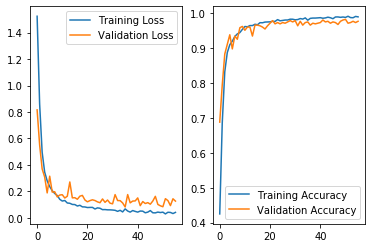

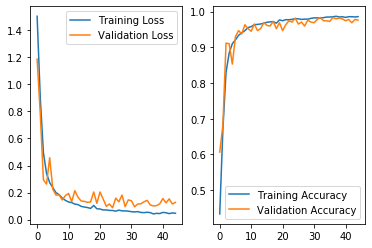

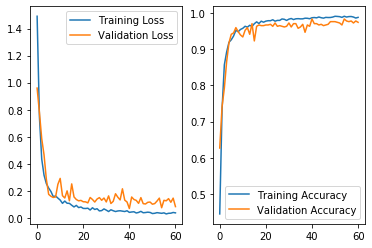

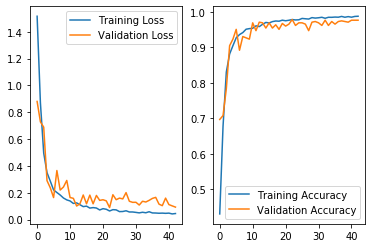

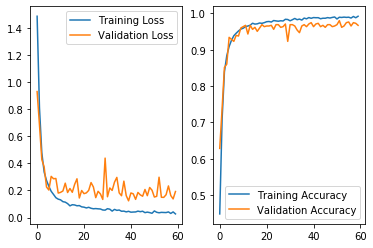

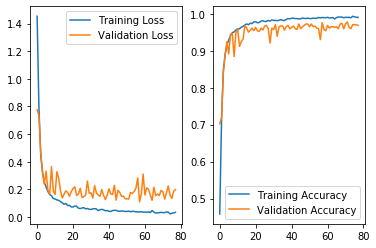

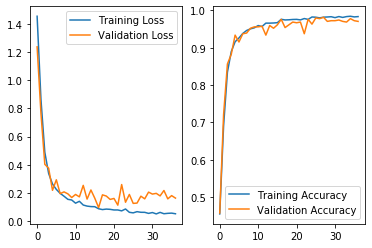

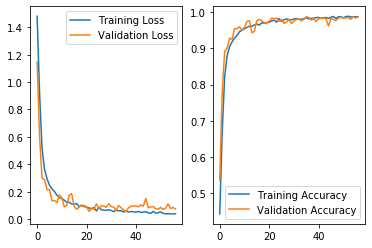

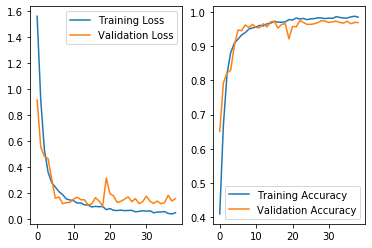

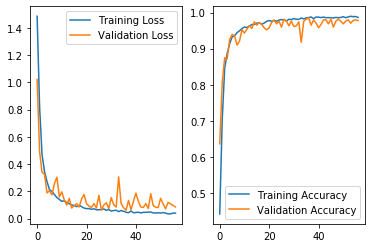

In [53]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [54]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.94111722 0.92570707 0.98041667 0.99338784 0.98860399
 0.8421267  0.961455  ]
precision sdev by class [0.         0.05404645 0.08058    0.02595736 0.00866008 0.02447491
 0.07779139 0.0282231 ]
macro precision mean 0.9541018095994287
macro precision sdev 0.021611277859950557
recall mean [0.93333333 0.98397436 0.89166667 0.97333333 0.98498305 0.95555556
 0.975      0.97256098]
recall sdev [0.2        0.03208332 0.098079   0.02905933 0.0055385  0.03628874
 0.05335937 0.02359212]
macro recall mean 0.9588009086786604
macro recall sdev 0.0258015363136693
f1 mean [0.95       0.96118234 0.90674572 0.97648781 0.98914736 0.97148041
 0.90175577 0.96670881]
f1 sdev [0.15       0.03517286 0.08253041 0.02005138 0.00572397 0.02574521
 0.05605516 0.02071206]
macro f1 mean 0.9529385258580456
macro f1 sdev 0.023340291323916833
accuracy mean 0.9751391608545467
accuracy sdev 0.011905499880825


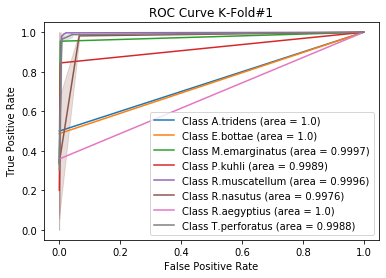

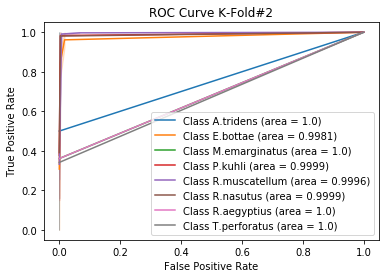

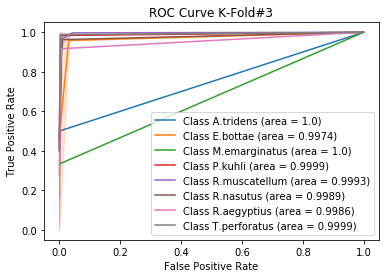

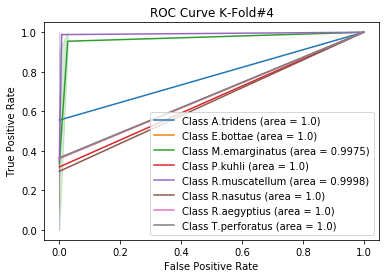

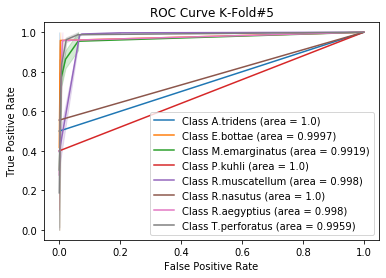

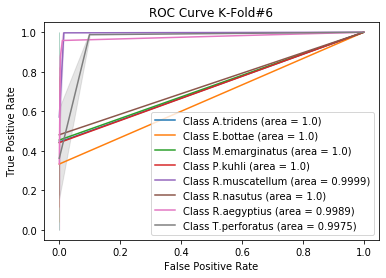

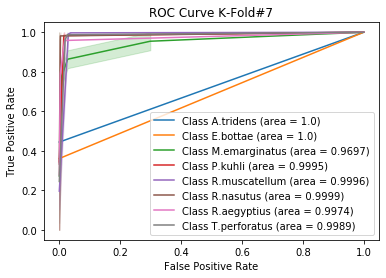

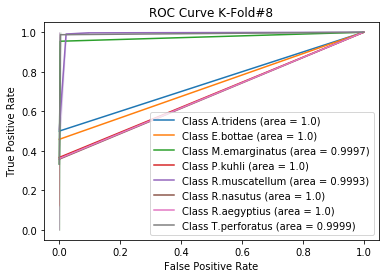

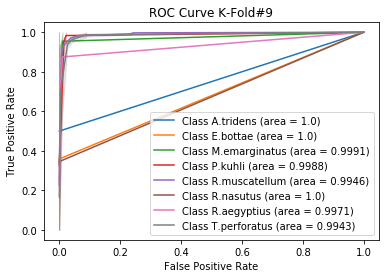

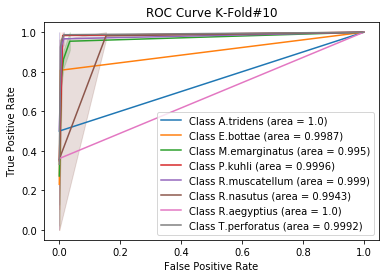

In [55]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [56]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.999392777798174
Std  0.0009131705360018806
Sp:  M.emarginatus
AUC Mean  0.9952494371371016
Std  0.008894111826334695
Sp:  P.kuhli
AUC Mean  0.999652889565195
Std  0.00044798072576636563
Sp:  R.muscatellum
AUC Mean  0.9988697176479391
Std  0.0015185488778113366
Sp:  R.nasutus
AUC Mean  0.9990547072906641
Std  0.0017427082280509346
Sp:  R.aegyptius
AUC Mean  0.9989932585610308
Std  0.001109027533910447
Sp:  T.perforatus
AUC Mean  0.9984449659053054
Std  0.001847655613739814


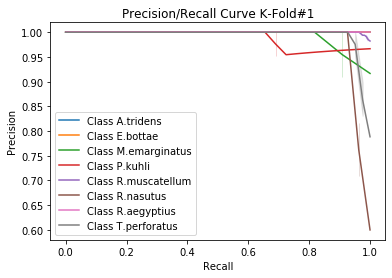

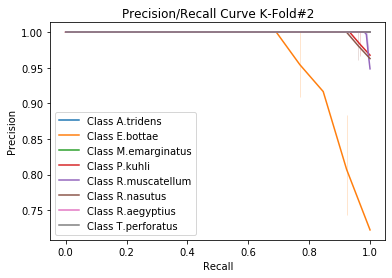

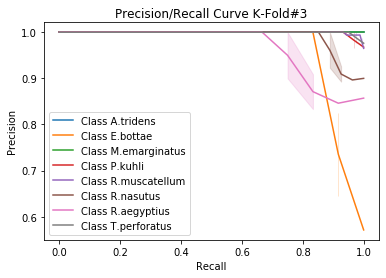

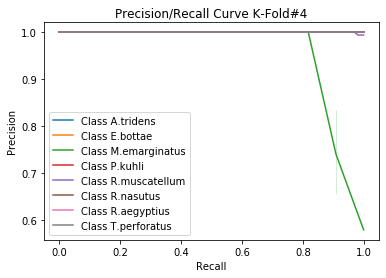

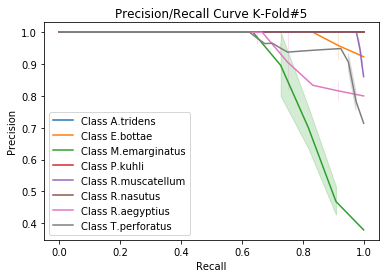

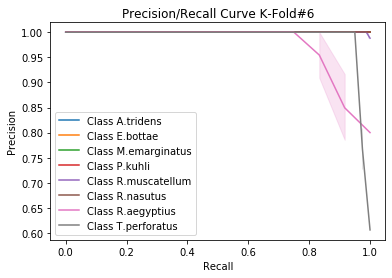

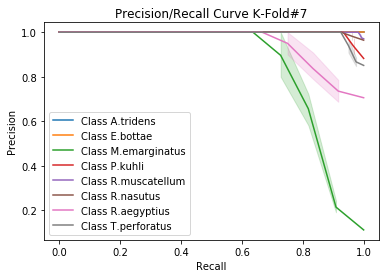

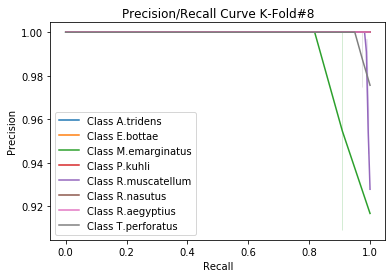

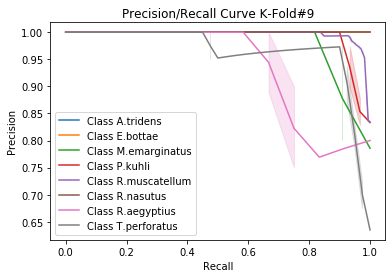

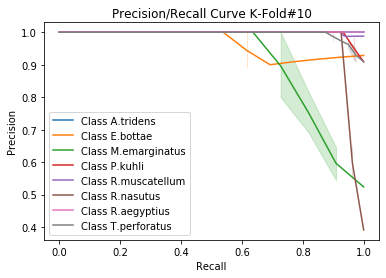

In [57]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  10   0   0   0   1   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 164   0   0   2]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   1]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   0   1   0   0]
 [  0   1   0   0 163   0   2   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   0  28   0   1   0   1]
 [  0   0   0   0 164   0   1   1]
 [  0   1   0   0   1  24   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

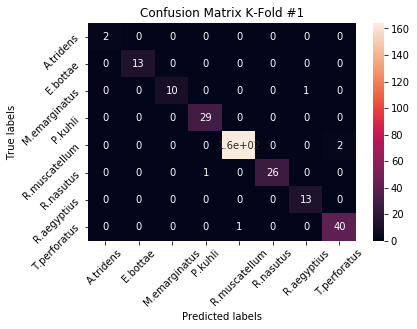

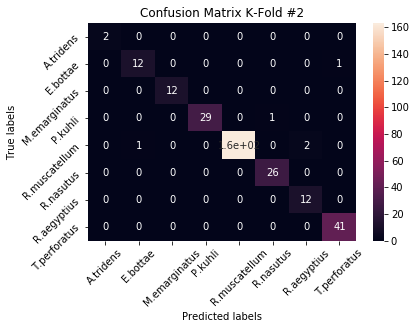

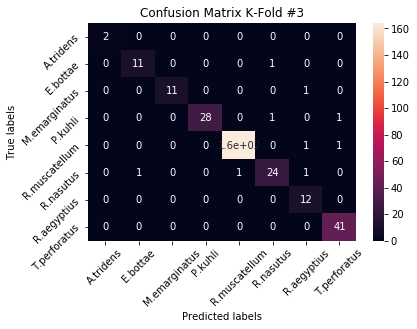

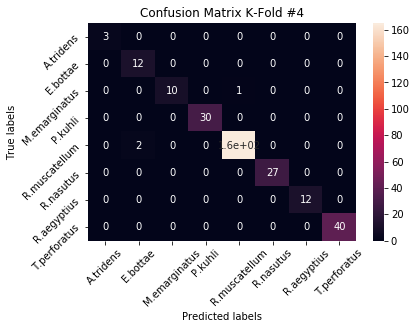

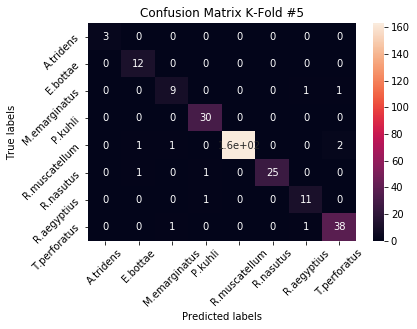

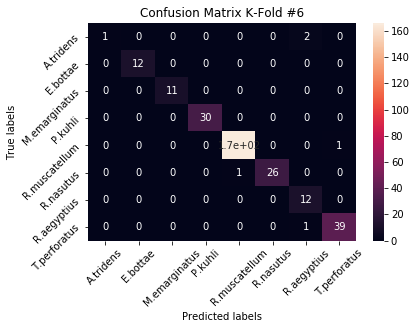

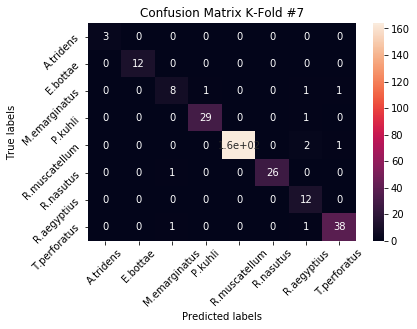

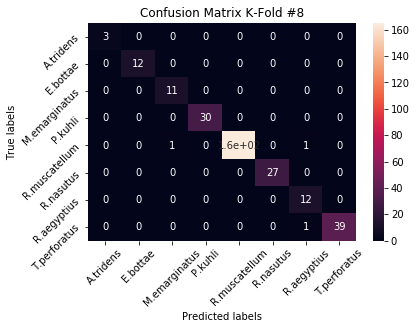

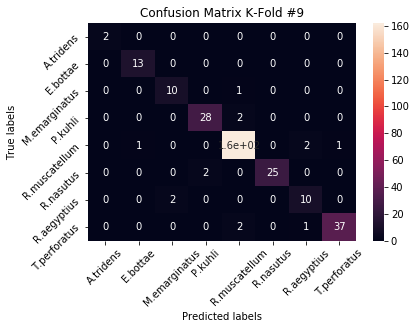

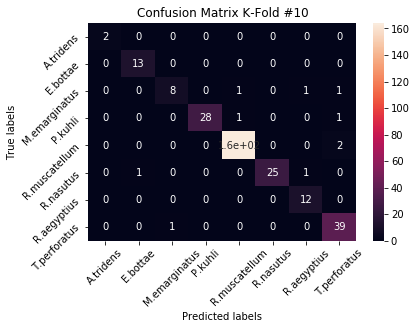

In [58]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  122    0    0    0    1    0    1]
 [   0    0  100    1    3    0    5    3]
 [   0    0    0  291    3    2    1    2]
 [   0    5    2    0 1640    0    8   10]
 [   0    3    1    4    2  257    2    0]
 [   0    0    2    1    0    0  118    0]
 [   0    0    3    0    3    0    5  392]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 164   0   0   1]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


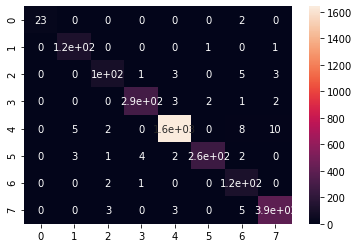

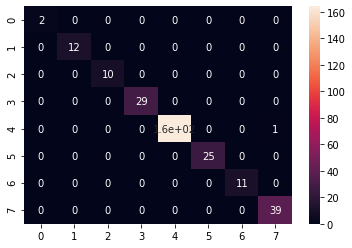

In [59]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.98 0.   0.   0.   0.01 0.   0.01]
 [0.   0.   0.89 0.01 0.03 0.   0.04 0.03]
 [0.   0.   0.   0.97 0.01 0.01 0.   0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.01 0.   0.01 0.01 0.96 0.01 0.  ]
 [0.   0.   0.02 0.01 0.   0.   0.98 0.  ]
 [0.   0.   0.01 0.   0.01 0.   0.01 0.97]]


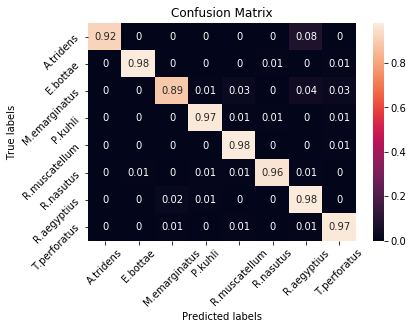

In [60]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V2 !!!!! K-Fold Training and Evaluation</h2>

In [62]:
folder = "models"
mode_version = "mel_smote_v2"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v2


In [63]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=248,kernel_size=(5,5),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [64]:
model = build_current_model()
model.summary()


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 56, 85, 120)       9120      
_________________________________________________________________
batch_normalization_115 (Bat (None, 56, 85, 120)       480       
_________________________________________________________________
activation_115 (Activation)  (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 14, 22, 120)       360

In [65]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 18s - loss: 1.6666 - acc: 0.3671 - val_loss: 1.2062 - val_acc: 0.5147
Epoch 2/100
9592/9592 - 14s - loss: 1.1806 - acc: 0.5686 - val_loss: 0.7261 - val_acc: 0.7408
Epoch 3/100
9592/9592 - 15s - loss: 0.7543 - acc: 0.7415 - val_loss: 0.4422 - val_acc: 0.8327
Epoch 4/100
9592/9592 - 15s - loss: 0.5202 - acc: 0.8296 - val_loss: 0.5425 - val_acc: 0.8180
Epoch 5/100
9592/9592 - 15s - loss: 0.3787 - acc: 0.8813 - val_loss: 0.2708 - val_acc: 0.9

Epoch 14/100
9592/9592 - 16s - loss: 0.1176 - acc: 0.9664 - val_loss: 0.1674 - val_acc: 0.9614
Epoch 15/100
9592/9592 - 17s - loss: 0.1107 - acc: 0.9644 - val_loss: 0.1251 - val_acc: 0.9743
Epoch 16/100
9592/9592 - 17s - loss: 0.1018 - acc: 0.9698 - val_loss: 0.1075 - val_acc: 0.9651
Epoch 17/100
9592/9592 - 17s - loss: 0.0869 - acc: 0.9729 - val_loss: 0.1175 - val_acc: 0.9632
Epoch 18/100
9592/9592 - 18s - loss: 0.0870 - acc: 0.9760 - val_loss: 0.0830 - val_acc: 0.9779
Epoch 19/100
9592/9592 - 17s - loss: 0.0781 - acc: 0.9763 - val_loss: 0.1106 - val_acc: 0.9743
Epoch 20/100
9592/9592 - 17s - loss: 0.0836 - acc: 0.9775 - val_loss: 0.1469 - val_acc: 0.9688
Epoch 21/100
9592/9592 - 18s - loss: 0.0768 - acc: 0.9789 - val_loss: 0.3130 - val_acc: 0.9136
Epoch 22/100
9592/9592 - 18s - loss: 0.0698 - acc: 0.9790 - val_loss: 0.1186 - val_acc: 0.9835
Epoch 23/100
9592/9592 - 18s - loss: 0.0686 - acc: 0.9814 - val_loss: 0.1365 - val_acc: 0.9651
Epoch 24/100
9592/9592 - 17s - loss: 0.0659 - acc:

Epoch 56/100
9592/9592 - 15s - loss: 0.0366 - acc: 0.9901 - val_loss: 0.1027 - val_acc: 0.9779
Epoch 57/100
9592/9592 - 16s - loss: 0.0346 - acc: 0.9905 - val_loss: 0.1151 - val_acc: 0.9724
Epoch 58/100
9592/9592 - 16s - loss: 0.0345 - acc: 0.9906 - val_loss: 0.0623 - val_acc: 0.9816
Epoch 59/100
9592/9592 - 15s - loss: 0.0249 - acc: 0.9933 - val_loss: 0.1237 - val_acc: 0.9761
Epoch 60/100
9592/9592 - 16s - loss: 0.0292 - acc: 0.9912 - val_loss: 0.1090 - val_acc: 0.9743
Epoch 61/100
9592/9592 - 16s - loss: 0.0333 - acc: 0.9902 - val_loss: 0.1008 - val_acc: 0.9779
Epoch 62/100
9592/9592 - 16s - loss: 0.0223 - acc: 0.9940 - val_loss: 0.1096 - val_acc: 0.9743
Epoch 63/100
9592/9592 - 15s - loss: 0.0198 - acc: 0.9938 - val_loss: 0.1172 - val_acc: 0.9706
Epoch 64/100
9592/9592 - 15s - loss: 0.0327 - acc: 0.9904 - val_loss: 0.1147 - val_acc: 0.9724
Epoch 65/100
9592/9592 - 15s - loss: 0.0192 - acc: 0.9945 - val_loss: 0.1027 - val_acc: 0.9724
Epoch 66/100
9592/9592 - 15s - loss: 0.0390 - acc:

Epoch 8/100
9584/9584 - 16s - loss: 0.2169 - acc: 0.9353 - val_loss: 0.2334 - val_acc: 0.9393
Epoch 9/100
9584/9584 - 16s - loss: 0.1744 - acc: 0.9492 - val_loss: 0.3496 - val_acc: 0.8934
Epoch 10/100
9584/9584 - 16s - loss: 0.1578 - acc: 0.9497 - val_loss: 0.2307 - val_acc: 0.9485
Epoch 11/100
9584/9584 - 16s - loss: 0.1394 - acc: 0.9584 - val_loss: 0.2412 - val_acc: 0.9412
Epoch 12/100
9584/9584 - 15s - loss: 0.1270 - acc: 0.9632 - val_loss: 0.2261 - val_acc: 0.9430
Epoch 13/100
9584/9584 - 16s - loss: 0.1068 - acc: 0.9689 - val_loss: 0.1896 - val_acc: 0.9393
Epoch 14/100
9584/9584 - 16s - loss: 0.1011 - acc: 0.9708 - val_loss: 0.2530 - val_acc: 0.9393
Epoch 15/100
9584/9584 - 16s - loss: 0.1002 - acc: 0.9694 - val_loss: 0.2568 - val_acc: 0.9467
Epoch 16/100
9584/9584 - 16s - loss: 0.0754 - acc: 0.9764 - val_loss: 0.1549 - val_acc: 0.9577
Epoch 17/100
9584/9584 - 16s - loss: 0.0996 - acc: 0.9721 - val_loss: 0.1528 - val_acc: 0.9688
Epoch 18/100
9584/9584 - 15s - loss: 0.0703 - acc: 0

Epoch 28/100
9584/9584 - 15s - loss: 0.0548 - acc: 0.9849 - val_loss: 0.1456 - val_acc: 0.9688
Epoch 29/100
9584/9584 - 16s - loss: 0.0433 - acc: 0.9885 - val_loss: 0.1898 - val_acc: 0.9651
Epoch 30/100
9584/9584 - 16s - loss: 0.0578 - acc: 0.9842 - val_loss: 0.2040 - val_acc: 0.9522
Epoch 31/100
9584/9584 - 16s - loss: 0.0534 - acc: 0.9847 - val_loss: 0.2108 - val_acc: 0.9577
Epoch 32/100
9584/9584 - 16s - loss: 0.0514 - acc: 0.9856 - val_loss: 0.1697 - val_acc: 0.9761
Epoch 33/100
9584/9584 - 16s - loss: 0.0484 - acc: 0.9867 - val_loss: 0.1454 - val_acc: 0.9669
Epoch 34/100
9584/9584 - 16s - loss: 0.0378 - acc: 0.9880 - val_loss: 0.1850 - val_acc: 0.9688
Epoch 35/100
9584/9584 - 16s - loss: 0.0442 - acc: 0.9861 - val_loss: 0.1589 - val_acc: 0.9632
Epoch 36/100
9584/9584 - 16s - loss: 0.0497 - acc: 0.9860 - val_loss: 0.1869 - val_acc: 0.9614
Epoch 37/100
9584/9584 - 15s - loss: 0.0392 - acc: 0.9893 - val_loss: 0.1897 - val_acc: 0.9540
Epoch 38/100
9584/9584 - 16s - loss: 0.0424 - acc:

Epoch 5/100
9584/9584 - 17s - loss: 0.4079 - acc: 0.8644 - val_loss: 0.2234 - val_acc: 0.9301
Epoch 6/100
9584/9584 - 17s - loss: 0.3247 - acc: 0.8959 - val_loss: 0.2203 - val_acc: 0.9467
Epoch 7/100
9584/9584 - 17s - loss: 0.2795 - acc: 0.9153 - val_loss: 0.2705 - val_acc: 0.9154
Epoch 8/100
9584/9584 - 17s - loss: 0.2240 - acc: 0.9305 - val_loss: 0.1422 - val_acc: 0.9577
Epoch 9/100
9584/9584 - 16s - loss: 0.1927 - acc: 0.9394 - val_loss: 0.1593 - val_acc: 0.9577
Epoch 10/100
9584/9584 - 17s - loss: 0.1912 - acc: 0.9441 - val_loss: 0.1753 - val_acc: 0.9338
Epoch 11/100
9584/9584 - 17s - loss: 0.1573 - acc: 0.9514 - val_loss: 0.1666 - val_acc: 0.9430
Epoch 12/100
9584/9584 - 17s - loss: 0.1404 - acc: 0.9593 - val_loss: 0.1020 - val_acc: 0.9669
Epoch 13/100
9584/9584 - 17s - loss: 0.1330 - acc: 0.9591 - val_loss: 0.1589 - val_acc: 0.9412
Epoch 14/100
9584/9584 - 17s - loss: 0.1108 - acc: 0.9659 - val_loss: 0.1362 - val_acc: 0.9559
Epoch 15/100
9584/9584 - 17s - loss: 0.1097 - acc: 0.96

Epoch 12/100
9592/9592 - 15s - loss: 0.1300 - acc: 0.9604 - val_loss: 0.1469 - val_acc: 0.9559
Epoch 13/100
9592/9592 - 15s - loss: 0.1235 - acc: 0.9638 - val_loss: 0.1404 - val_acc: 0.9559
Epoch 14/100
9592/9592 - 15s - loss: 0.1145 - acc: 0.9662 - val_loss: 0.0967 - val_acc: 0.9688
Epoch 15/100
9592/9592 - 14s - loss: 0.1116 - acc: 0.9689 - val_loss: 0.1654 - val_acc: 0.9651
Epoch 16/100
9592/9592 - 14s - loss: 0.1048 - acc: 0.9678 - val_loss: 0.1955 - val_acc: 0.9320
Epoch 17/100
9592/9592 - 15s - loss: 0.0868 - acc: 0.9746 - val_loss: 0.1483 - val_acc: 0.9485
Epoch 18/100
9592/9592 - 15s - loss: 0.0902 - acc: 0.9724 - val_loss: 0.0952 - val_acc: 0.9688
Epoch 19/100
9592/9592 - 15s - loss: 0.0853 - acc: 0.9752 - val_loss: 0.1172 - val_acc: 0.9632
Epoch 20/100
9592/9592 - 15s - loss: 0.0770 - acc: 0.9762 - val_loss: 0.1242 - val_acc: 0.9596
Epoch 21/100
9592/9592 - 15s - loss: 0.0682 - acc: 0.9810 - val_loss: 0.1203 - val_acc: 0.9743
Epoch 22/100
9592/9592 - 14s - loss: 0.0708 - acc:

In [66]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_smote_v2_iter_1.model
File Name Loaded:  models/mel_smote_v2_iter_2.model
File Name Loaded:  models/mel_smote_v2_iter_3.model
File Name Loaded:  models/mel_smote_v2_iter_4.model
File Name Loaded:  models/mel_smote_v2_iter_5.model
File Name Loaded:  models/mel_smote_v2_iter_6.model
File Name Loaded:  models/mel_smote_v2_iter_7.model
File Name Loaded:  models/mel_smote_v2_iter_8.model
File Name Loaded:  models/mel_smote_v2_iter_9.model
File Name Loaded:  models/mel_smote_v2_iter_10.model


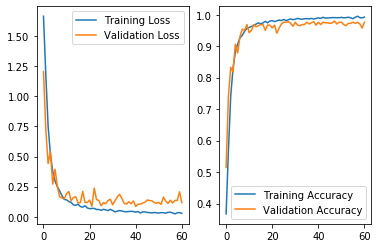

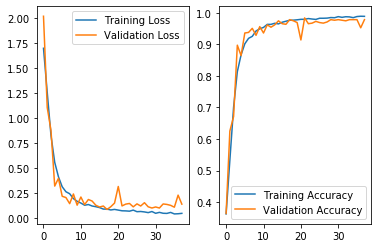

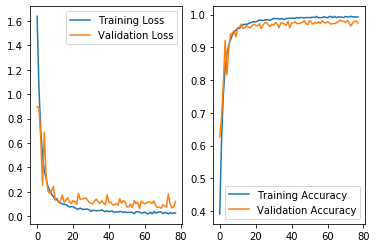

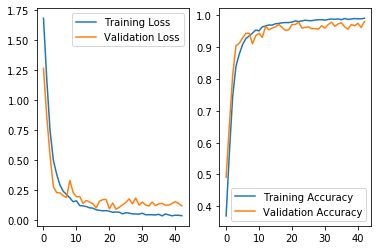

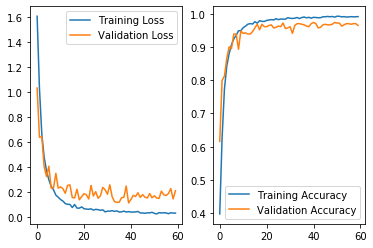

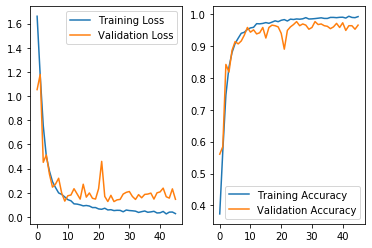

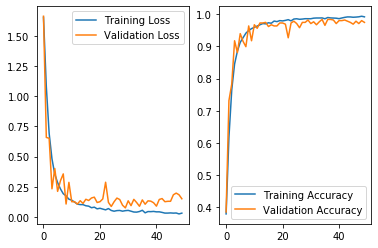

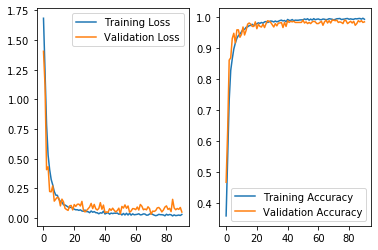

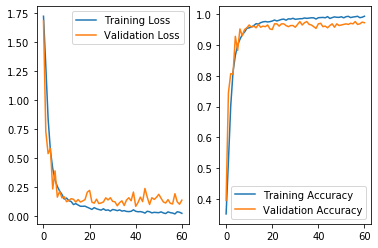

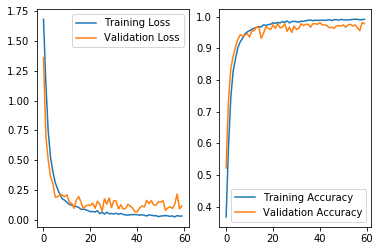

In [67]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [68]:
print_metrics(kFold_metrics)


precision mean by class [0.975      0.9478022  0.91919913 0.97394201 0.99097716 0.98860399
 0.82652237 0.95699504]
precision sdev by class [0.075      0.03424713 0.06212386 0.02397119 0.00664054 0.01741158
 0.07744263 0.03782522]
macro precision mean 0.9473802377309145
macro precision sdev 0.023269399904352357
recall mean [0.93333333 0.97564103 0.86515152 0.97666667 0.98138302 0.9480057
 0.96666667 0.9727439 ]
recall sdev [0.2        0.03724574 0.10106186 0.03349959 0.00681564 0.02956141
 0.05527708 0.02322691]
macro recall mean 0.9524489781252831
macro recall sdev 0.026249834174574396
f1 mean [0.93571429 0.96050093 0.88765505 0.97489931 0.98611674 0.96762587
 0.88797509 0.96452331]
f1 sdev [0.15135443 0.01735321 0.0626959  0.02180079 0.00242716 0.01921155
 0.04903428 0.02693707]
macro f1 mean 0.9456263235058053
macro f1 sdev 0.02395816739517868
accuracy mean 0.9711678510923851
accuracy sdev 0.00853583430483586


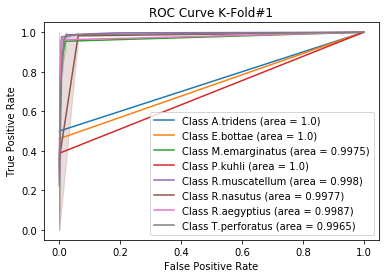

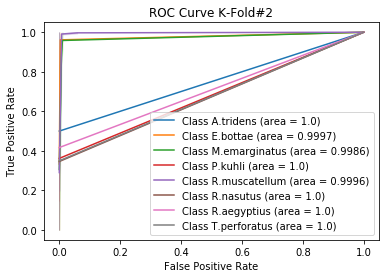

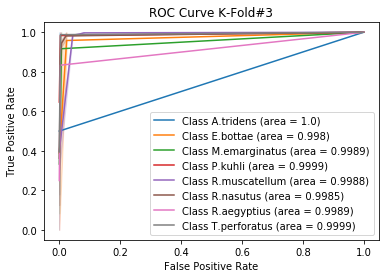

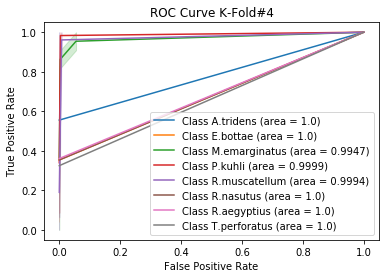

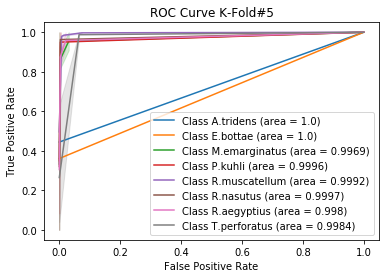

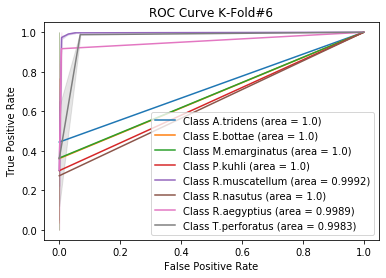

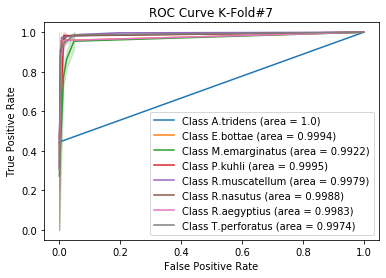

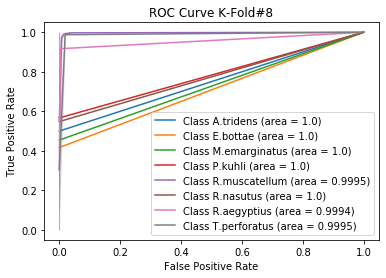

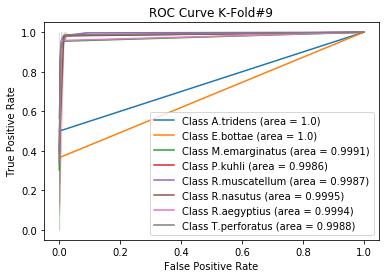

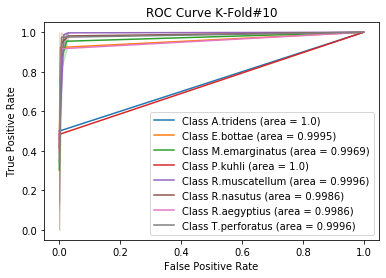

In [69]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [70]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9996613435252918
Std  0.0005988092267601148
Sp:  M.emarginatus
AUC Mean  0.9974594415538247
Std  0.0023400895892304843
Sp:  P.kuhli
AUC Mean  0.9997544045293394
Std  0.00040409990599157055
Sp:  R.muscatellum
AUC Mean  0.9989925967421012
Std  0.0006047213429427335
Sp:  R.nasutus
AUC Mean  0.9992855071395219
Std  0.0007741547151211526
Sp:  R.aegyptius
AUC Mean  0.9990041501075387
Std  0.0006524291606668532
Sp:  T.perforatus
AUC Mean  0.9988427447745127
Std  0.0011276208557297733


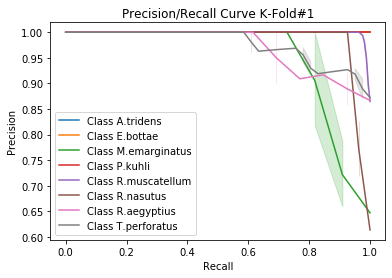

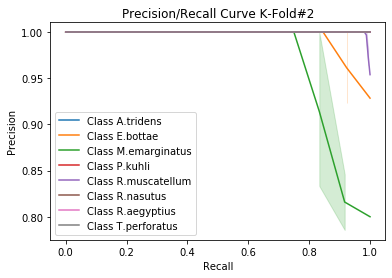

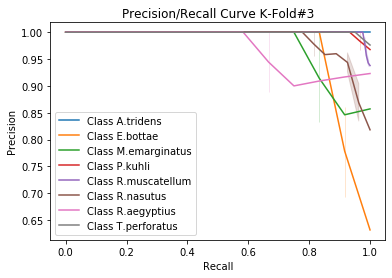

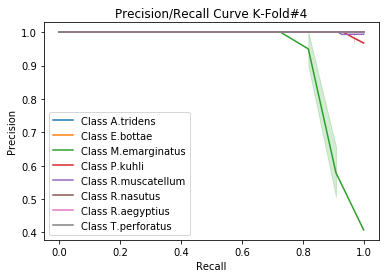

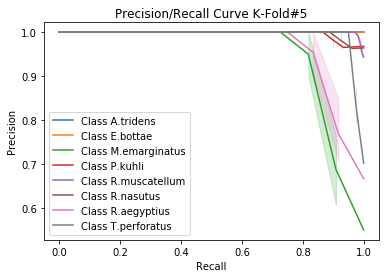

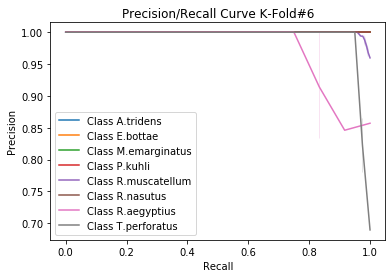

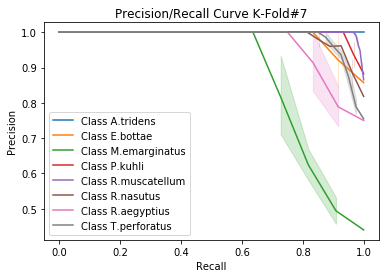

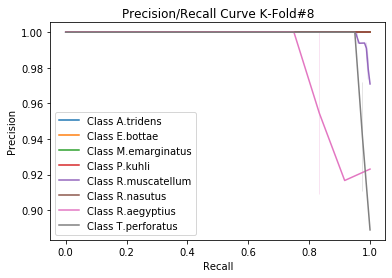

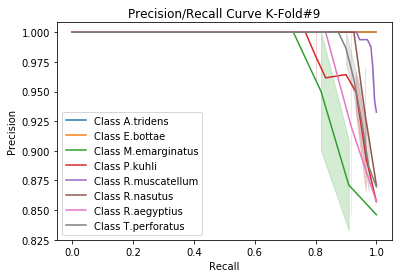

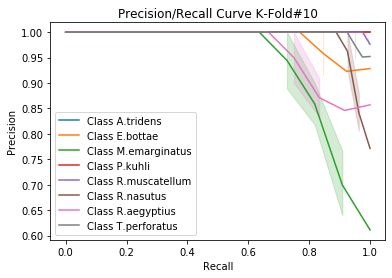

In [71]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   9   0   0   0   2   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 163   0   0   3]
 [  0   0   0   0   0  26   1   0]
 [  0   0   0   0   0   0  13   0]
 [  0   1   0   0   2   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  10   0   0   0   2   0]
 [  0   0   0  30   0   0   0   0]
 [  0   1   1   0 162   0   2   0]
 [  0   0   0   1   0  25   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   0   1   1 163   0   1   0]
 [  0   0   1   1   0  25   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

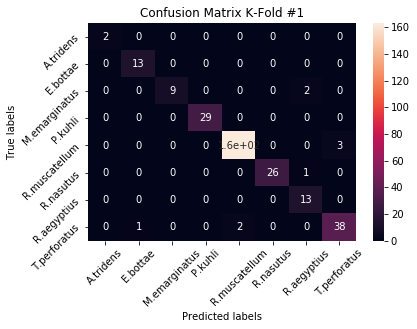

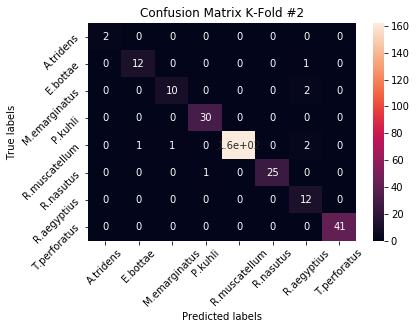

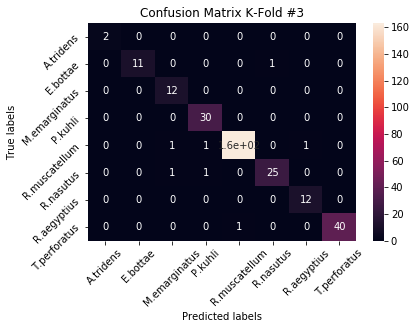

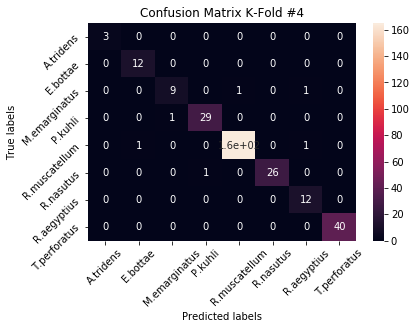

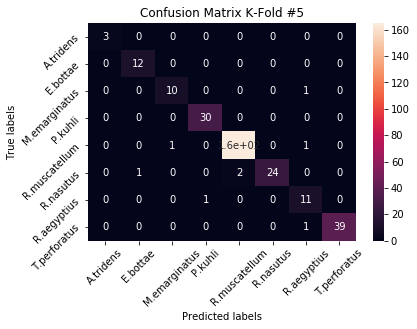

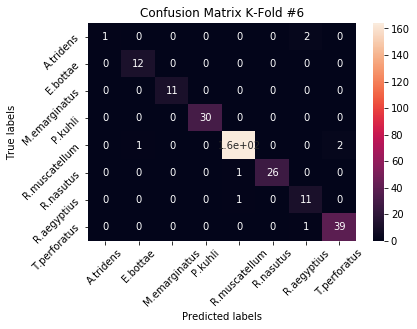

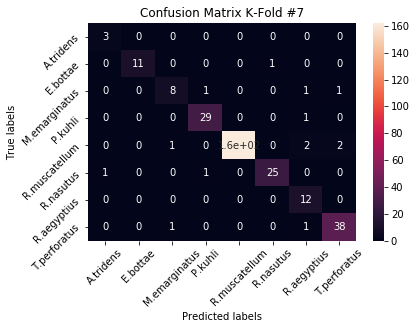

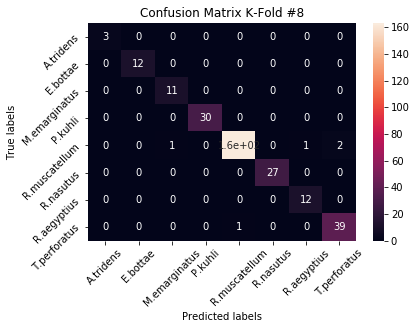

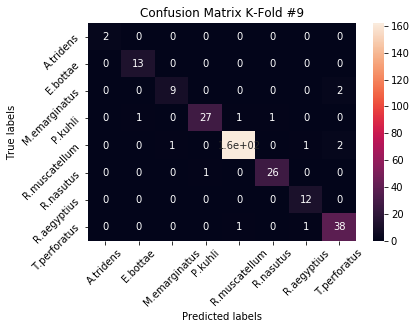

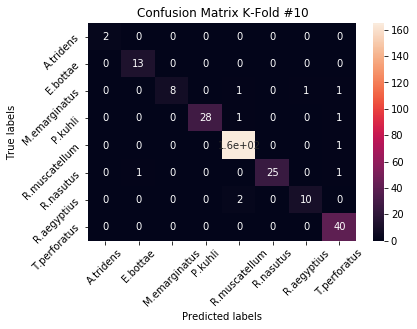

In [72]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  121    0    0    0    2    1    0]
 [   0    0   97    1    2    0    8    4]
 [   0    1    1  292    2    1    1    1]
 [   0    3    6    1 1634    0    9   12]
 [   1    2    1    5    3  255    1    1]
 [   0    0    0    1    3    0  117    0]
 [   0    1    1    0    5    0    4  392]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 163   0   0   1]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


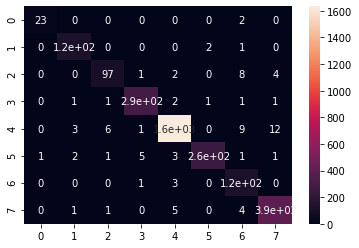

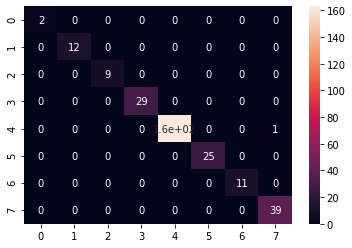

In [73]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.98 0.   0.   0.   0.02 0.01 0.  ]
 [0.   0.   0.87 0.01 0.02 0.   0.07 0.04]
 [0.   0.   0.   0.98 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.01 0.01]
 [0.   0.01 0.   0.02 0.01 0.95 0.   0.  ]
 [0.   0.   0.   0.01 0.02 0.   0.97 0.  ]
 [0.   0.   0.   0.   0.01 0.   0.01 0.97]]


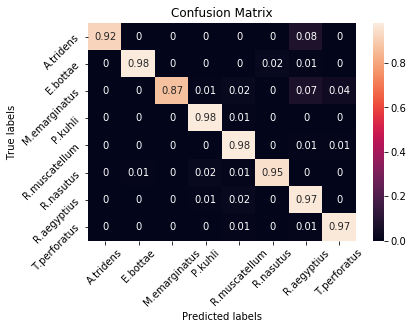

In [74]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V3 !!!!! K-Fold Training and Evaluation</h2>

In [75]:
folder = "models"
mode_version = "mel_smote_v3"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v3


In [76]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=152,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [77]:
model = build_current_model()
model.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_192 (Bat (None, 56, 85, 120)       480       
_________________________________________________________________
activation_192 (Activation)  (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_192 (Dropout)        (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 14, 22, 152)       456

In [78]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 21s - loss: 1.6964 - acc: 0.3636 - val_loss: 1.4210 - val_acc: 0.4338
Epoch 2/100
9592/9592 - 16s - loss: 1.2867 - acc: 0.5194 - val_loss: 1.2696 - val_acc: 0.4651
Epoch 3/100
9592/9592 - 16s - loss: 0.8517 - acc: 0.6967 - val_loss: 0.6424 - val_acc: 0.7831
Epoch 4/100
9592/9592 - 16s - loss: 0.5592 - acc: 0.8129 - val_loss: 0.3416 - val_acc: 0.8695
Epoch 5/100
9592/9592 - 16s - loss: 0.3993 - acc: 0.8755 - val_loss: 0.3530 - val_acc: 0.8

Epoch 20/100
9592/9592 - 17s - loss: 0.0777 - acc: 0.9775 - val_loss: 0.0716 - val_acc: 0.9816
Epoch 21/100
9592/9592 - 17s - loss: 0.0798 - acc: 0.9754 - val_loss: 0.1284 - val_acc: 0.9688
Epoch 22/100
9592/9592 - 17s - loss: 0.0688 - acc: 0.9798 - val_loss: 0.1796 - val_acc: 0.9430
Epoch 23/100
9592/9592 - 17s - loss: 0.0651 - acc: 0.9809 - val_loss: 0.1097 - val_acc: 0.9798
Epoch 24/100
9592/9592 - 17s - loss: 0.0757 - acc: 0.9783 - val_loss: 0.0994 - val_acc: 0.9816
Epoch 25/100
9592/9592 - 17s - loss: 0.0647 - acc: 0.9817 - val_loss: 0.1667 - val_acc: 0.9577
Epoch 26/100
9592/9592 - 17s - loss: 0.0653 - acc: 0.9822 - val_loss: 0.0995 - val_acc: 0.9816
Epoch 27/100
9592/9592 - 17s - loss: 0.0575 - acc: 0.9828 - val_loss: 0.1307 - val_acc: 0.9724
Epoch 28/100
9592/9592 - 17s - loss: 0.0558 - acc: 0.9843 - val_loss: 0.2027 - val_acc: 0.9614
Epoch 29/100
9592/9592 - 16s - loss: 0.0585 - acc: 0.9825 - val_loss: 0.1170 - val_acc: 0.9761
Epoch 30/100
9592/9592 - 18s - loss: 0.0500 - acc:

Epoch 3/100
9584/9584 - 17s - loss: 0.7642 - acc: 0.7269 - val_loss: 0.7577 - val_acc: 0.7353
Epoch 4/100
9584/9584 - 17s - loss: 0.5300 - acc: 0.8210 - val_loss: 0.3621 - val_acc: 0.8750
Epoch 5/100
9584/9584 - 16s - loss: 0.3934 - acc: 0.8711 - val_loss: 0.2606 - val_acc: 0.9026
Epoch 6/100
9584/9584 - 17s - loss: 0.3247 - acc: 0.8983 - val_loss: 0.4849 - val_acc: 0.8474
Epoch 7/100
9584/9584 - 17s - loss: 0.2638 - acc: 0.9165 - val_loss: 0.6146 - val_acc: 0.8290
Epoch 8/100
9584/9584 - 17s - loss: 0.2144 - acc: 0.9329 - val_loss: 0.2160 - val_acc: 0.9301
Epoch 9/100
9584/9584 - 17s - loss: 0.1900 - acc: 0.9438 - val_loss: 0.2109 - val_acc: 0.9265
Epoch 10/100
9584/9584 - 16s - loss: 0.1777 - acc: 0.9478 - val_loss: 0.2346 - val_acc: 0.9338
Epoch 11/100
9584/9584 - 17s - loss: 0.1602 - acc: 0.9532 - val_loss: 0.2207 - val_acc: 0.9320
Epoch 12/100
9584/9584 - 17s - loss: 0.1388 - acc: 0.9570 - val_loss: 0.1648 - val_acc: 0.9540
Epoch 13/100
9584/9584 - 17s - loss: 0.1206 - acc: 0.9643

Epoch 19/100
9584/9584 - 17s - loss: 0.0790 - acc: 0.9778 - val_loss: 0.1242 - val_acc: 0.9706
Epoch 20/100
9584/9584 - 18s - loss: 0.0764 - acc: 0.9776 - val_loss: 0.1590 - val_acc: 0.9632
Epoch 21/100
9584/9584 - 17s - loss: 0.0709 - acc: 0.9795 - val_loss: 0.1520 - val_acc: 0.9669
Epoch 22/100
9584/9584 - 17s - loss: 0.0631 - acc: 0.9824 - val_loss: 0.2461 - val_acc: 0.9540
Epoch 23/100
9584/9584 - 17s - loss: 0.0704 - acc: 0.9793 - val_loss: 0.1568 - val_acc: 0.9724
Epoch 24/100
9584/9584 - 17s - loss: 0.0594 - acc: 0.9835 - val_loss: 0.1917 - val_acc: 0.9540
Epoch 25/100
9584/9584 - 17s - loss: 0.0612 - acc: 0.9827 - val_loss: 0.1427 - val_acc: 0.9724
Epoch 26/100
9584/9584 - 17s - loss: 0.0557 - acc: 0.9828 - val_loss: 0.1617 - val_acc: 0.9688
Epoch 27/100
9584/9584 - 17s - loss: 0.0617 - acc: 0.9834 - val_loss: 0.1437 - val_acc: 0.9724
Epoch 28/100
9584/9584 - 17s - loss: 0.0572 - acc: 0.9833 - val_loss: 0.2479 - val_acc: 0.9467
Epoch 29/100
9584/9584 - 18s - loss: 0.0507 - acc:

Epoch 29/100
9584/9584 - 17s - loss: 0.0559 - acc: 0.9839 - val_loss: 0.1008 - val_acc: 0.9651
Epoch 30/100
9584/9584 - 17s - loss: 0.0512 - acc: 0.9861 - val_loss: 0.0808 - val_acc: 0.9871
Epoch 31/100
9584/9584 - 16s - loss: 0.0578 - acc: 0.9838 - val_loss: 0.0744 - val_acc: 0.9853
Epoch 32/100
9584/9584 - 17s - loss: 0.0524 - acc: 0.9850 - val_loss: 0.1188 - val_acc: 0.9688
Epoch 33/100
9584/9584 - 17s - loss: 0.0547 - acc: 0.9858 - val_loss: 0.0951 - val_acc: 0.9761
Epoch 34/100
9584/9584 - 17s - loss: 0.0533 - acc: 0.9839 - val_loss: 0.1198 - val_acc: 0.9761
Epoch 35/100
9584/9584 - 17s - loss: 0.0554 - acc: 0.9843 - val_loss: 0.1330 - val_acc: 0.9651
Epoch 36/100
9584/9584 - 17s - loss: 0.0410 - acc: 0.9898 - val_loss: 0.0902 - val_acc: 0.9706
Epoch 37/100
9584/9584 - 17s - loss: 0.0466 - acc: 0.9875 - val_loss: 0.0745 - val_acc: 0.9853
Epoch 38/100
9584/9584 - 17s - loss: 0.0532 - acc: 0.9858 - val_loss: 0.1213 - val_acc: 0.9761
Epoch 39/100
9584/9584 - 17s - loss: 0.0500 - acc:

Epoch 23/100
9592/9592 - 16s - loss: 0.0717 - acc: 0.9796 - val_loss: 0.1298 - val_acc: 0.9596
Epoch 24/100
9592/9592 - 15s - loss: 0.0610 - acc: 0.9826 - val_loss: 0.0887 - val_acc: 0.9743
Epoch 25/100
9592/9592 - 15s - loss: 0.0599 - acc: 0.9830 - val_loss: 0.1113 - val_acc: 0.9724
Epoch 26/100
9592/9592 - 15s - loss: 0.0713 - acc: 0.9796 - val_loss: 0.0905 - val_acc: 0.9779
Epoch 27/100
9592/9592 - 15s - loss: 0.0439 - acc: 0.9878 - val_loss: 0.0991 - val_acc: 0.9706
Epoch 28/100
9592/9592 - 15s - loss: 0.0716 - acc: 0.9806 - val_loss: 0.1262 - val_acc: 0.9706
Epoch 29/100
9592/9592 - 15s - loss: 0.0531 - acc: 0.9845 - val_loss: 0.1021 - val_acc: 0.9761
Epoch 30/100
9592/9592 - 15s - loss: 0.0630 - acc: 0.9817 - val_loss: 0.0988 - val_acc: 0.9706
Epoch 31/100
Restoring model weights from the end of the best epoch.
9592/9592 - 19s - loss: 0.0526 - acc: 0.9846 - val_loss: 0.1194 - val_acc: 0.9688
Epoch 00031: early stopping
models/mel_smote_v3_iter_10.model


In [79]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_smote_v3_iter_1.model
File Name Loaded:  models/mel_smote_v3_iter_2.model
File Name Loaded:  models/mel_smote_v3_iter_3.model
File Name Loaded:  models/mel_smote_v3_iter_4.model
File Name Loaded:  models/mel_smote_v3_iter_5.model
File Name Loaded:  models/mel_smote_v3_iter_6.model
File Name Loaded:  models/mel_smote_v3_iter_7.model
File Name Loaded:  models/mel_smote_v3_iter_8.model
File Name Loaded:  models/mel_smote_v3_iter_9.model
File Name Loaded:  models/mel_smote_v3_iter_10.model


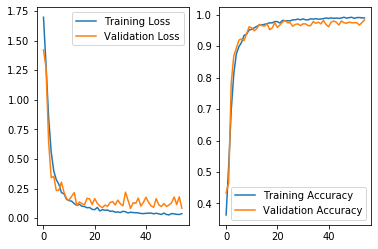

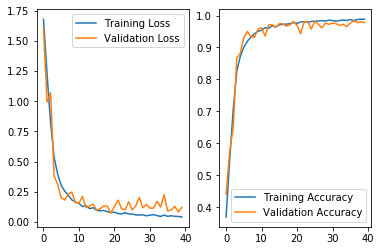

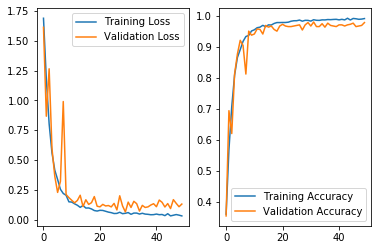

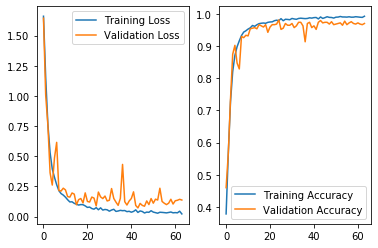

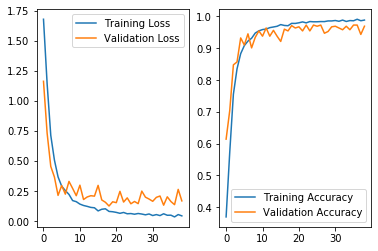

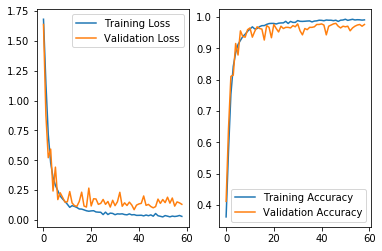

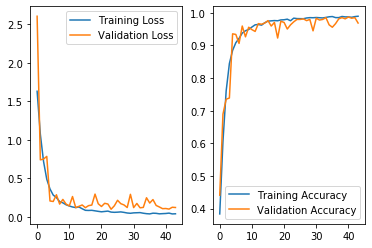

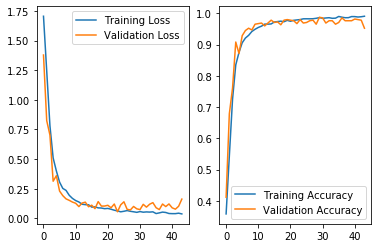

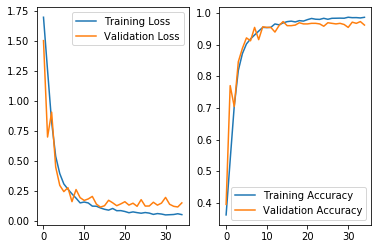

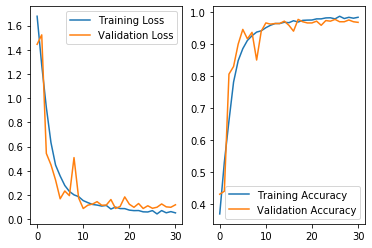

In [80]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [81]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.9409707  0.89549519 0.99021505 0.99221372 0.98118641
 0.83040182 0.97095802]
precision sdev by class [0.         0.06314396 0.13035602 0.01494933 0.01027075 0.02550331
 0.09600123 0.03505855]
macro precision mean 0.9501801135237677
macro precision sdev 0.02533780373933359
recall mean [0.93333333 0.96025641 0.90075758 0.98       0.98318664 0.96638177
 0.95       0.96518293]
recall sdev [0.2        0.05261099 0.07564006 0.02666667 0.01282863 0.03897619
 0.07637626 0.03550587]
macro recall mean 0.9548873314161257
macro recall sdev 0.02715775666153094
f1 mean [0.95       0.94940675 0.89041907 0.98479651 0.98761387 0.97349698
 0.88289905 0.96751052]
f1 sdev [0.15       0.04882933 0.07705954 0.0141511  0.00849915 0.0295604
 0.07563717 0.02696865]
macro f1 mean 0.9482678442204712
macro f1 sdev 0.026495968339436373
accuracy mean 0.9731502057160458
accuracy sdev 0.012901281847816432


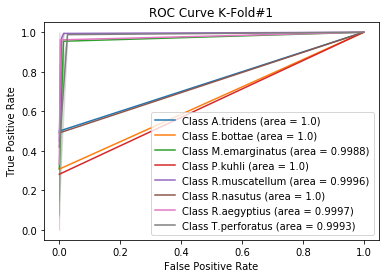

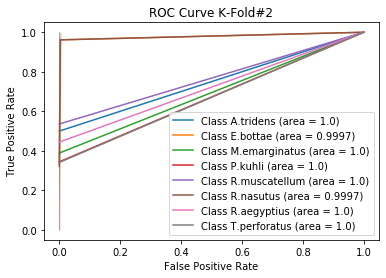

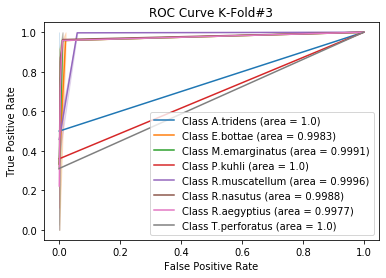

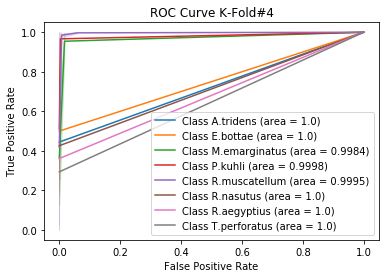

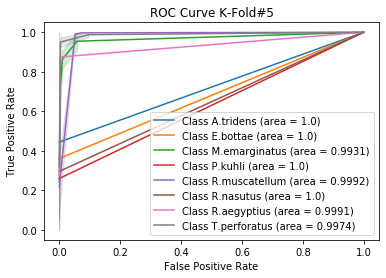

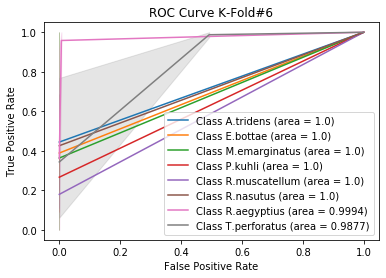

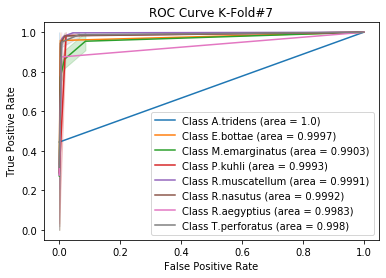

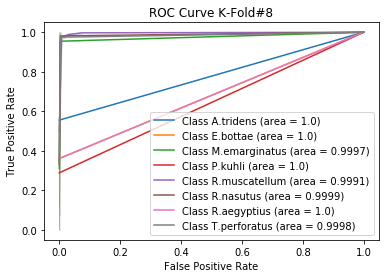

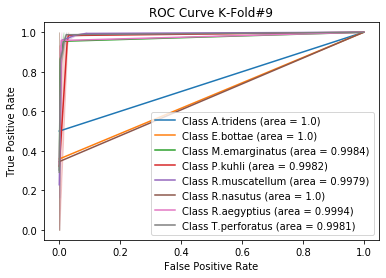

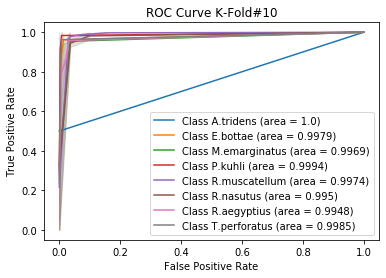

In [82]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [83]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9995585583794032
Std  0.0007578307384916442
Sp:  M.emarginatus
AUC Mean  0.9974754387098859
Std  0.0030727329389872433
Sp:  P.kuhli
AUC Mean  0.9996559583242892
Std  0.0005656332193346865
Sp:  R.muscatellum
AUC Mean  0.9991501362186253
Std  0.0008044971237178548
Sp:  R.nasutus
AUC Mean  0.999256505932799
Std  0.0014732186992726867
Sp:  R.aegyptius
AUC Mean  0.9988507047381286
Std  0.0015318221323651349
Sp:  T.perforatus
AUC Mean  0.9978817426993695
Std  0.0035182538652067086


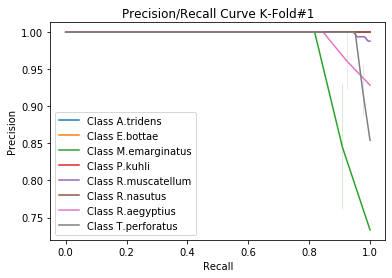

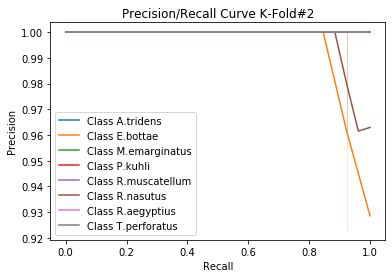

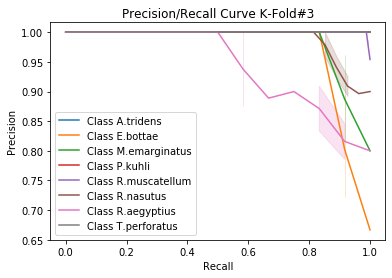

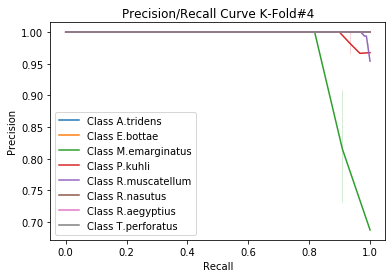

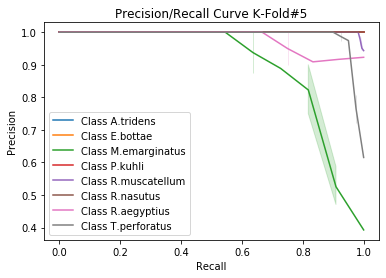

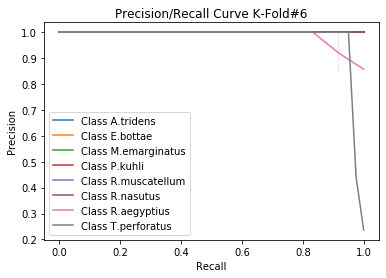

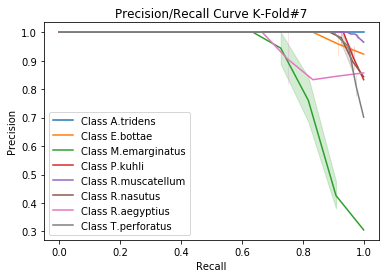

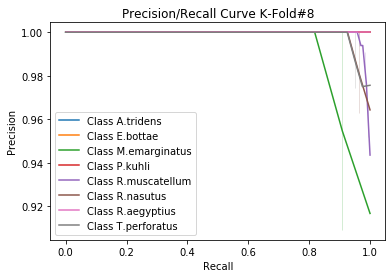

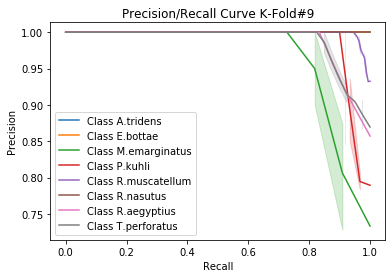

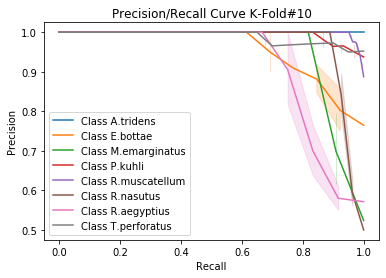

In [84]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1  10   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   0  27   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   1   0   0   2   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   1   0   0   0  24   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   1  28   0   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   1   1   0   0  24   1   0]
 [  0   0   1   0   0   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

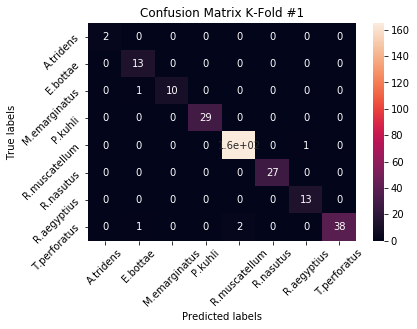

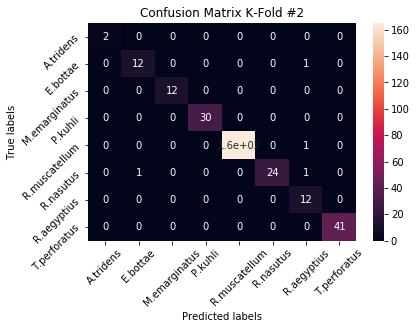

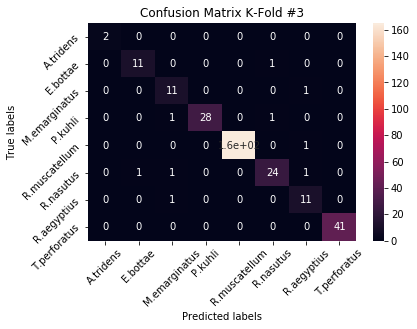

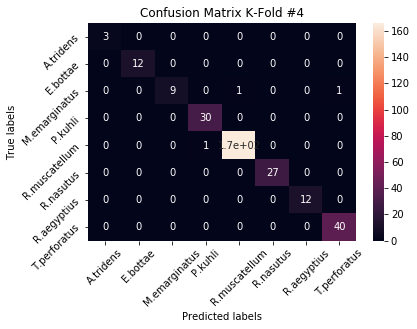

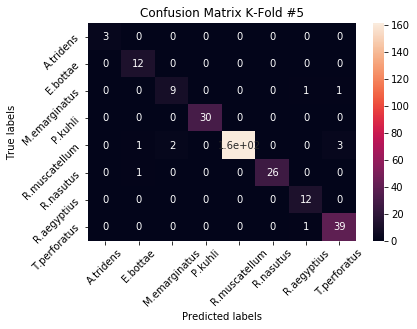

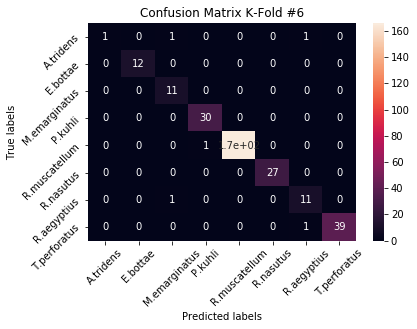

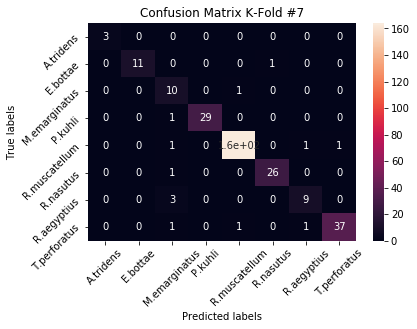

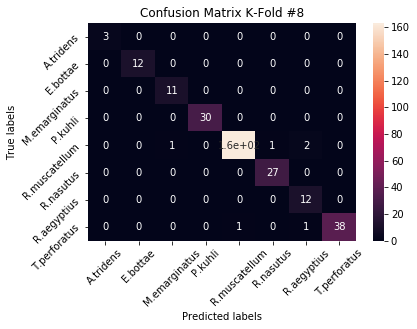

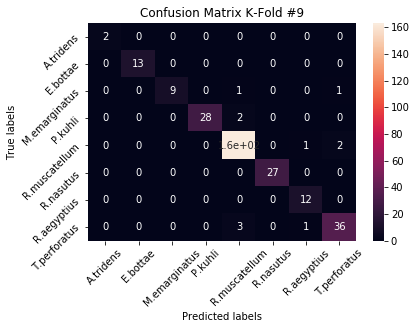

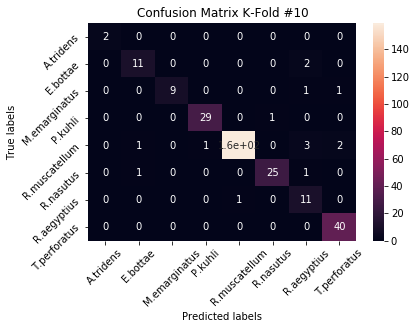

In [85]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    1    0    0    0    1    0]
 [   0  119    0    0    0    2    3    0]
 [   0    1  101    0    3    0    3    4]
 [   0    0    2  293    2    2    0    0]
 [   0    2    4    3 1637    1   10    8]
 [   0    4    2    0    0  260    3    0]
 [   0    0    5    0    1    0  115    0]
 [   0    1    1    0    7    0    5  389]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 163   0   1   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  38]]


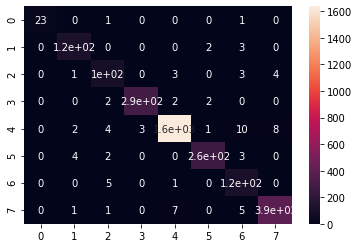

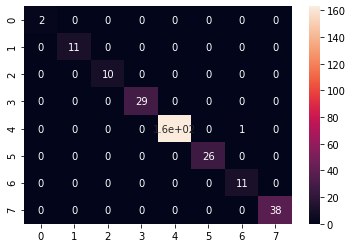

In [86]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.04 0.   0.   0.   0.04 0.  ]
 [0.   0.96 0.   0.   0.   0.02 0.02 0.  ]
 [0.   0.01 0.9  0.   0.03 0.   0.03 0.04]
 [0.   0.   0.01 0.98 0.01 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.01 0.  ]
 [0.   0.01 0.01 0.   0.   0.97 0.01 0.  ]
 [0.   0.   0.04 0.   0.01 0.   0.95 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.01 0.97]]


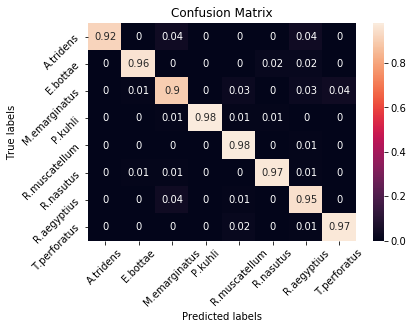

In [87]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V4 !!!!! K-Fold Training and Evaluation</h2>

In [18]:
folder = "models"
mode_version = "mel_smote_v4"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v4


In [19]:

def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(256)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(64)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [20]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 56)        0         
_________

In [21]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 10s - loss: 1.7396 - acc: 0.3407 - val_loss: 1.7981 - val_acc: 0.3419
Epoch 2/100
9592/9592 - 8s - loss: 1.3842 - acc: 0.4770 - val_loss: 1.0432 - val_acc: 0.5864
Epoch 3/100
9592/9592 - 9s - loss: 1.0917 - acc: 0.5999 - val_loss: 0.8891 - val_acc: 0.6415
Epoch 4/100
9592/9592 - 8s - loss: 0.8366 - acc: 0.7132 - val_loss: 0.5911 - val_acc: 0.7702
Epoch 5/100
9592/9592 - 9s - loss: 0.6532 - acc: 0.7866 - val_loss: 0.4989 - val_acc: 0.8548


Epoch 41/100
9592/9592 - 10s - loss: 0.0752 - acc: 0.9786 - val_loss: 0.1326 - val_acc: 0.9688
Epoch 42/100
9592/9592 - 10s - loss: 0.0754 - acc: 0.9782 - val_loss: 0.0985 - val_acc: 0.9816
Epoch 43/100
9592/9592 - 10s - loss: 0.0786 - acc: 0.9779 - val_loss: 0.1293 - val_acc: 0.9743
Epoch 44/100
9592/9592 - 10s - loss: 0.0860 - acc: 0.9779 - val_loss: 0.1132 - val_acc: 0.9724
Epoch 45/100
9592/9592 - 11s - loss: 0.0803 - acc: 0.9783 - val_loss: 0.1060 - val_acc: 0.9743
Epoch 46/100
9592/9592 - 10s - loss: 0.0659 - acc: 0.9828 - val_loss: 0.1400 - val_acc: 0.9761
Epoch 47/100
9592/9592 - 10s - loss: 0.0721 - acc: 0.9796 - val_loss: 0.1314 - val_acc: 0.9743
Epoch 48/100
9592/9592 - 10s - loss: 0.0764 - acc: 0.9766 - val_loss: 0.0884 - val_acc: 0.9835
Epoch 49/100
9592/9592 - 11s - loss: 0.0777 - acc: 0.9787 - val_loss: 0.0908 - val_acc: 0.9798
Epoch 50/100
9592/9592 - 10s - loss: 0.0756 - acc: 0.9785 - val_loss: 0.1078 - val_acc: 0.9724
Epoch 51/100
9592/9592 - 10s - loss: 0.0606 - acc:

Epoch 23/100
9592/9592 - 8s - loss: 0.1182 - acc: 0.9652 - val_loss: 0.1700 - val_acc: 0.9504
Epoch 24/100
9592/9592 - 8s - loss: 0.1093 - acc: 0.9665 - val_loss: 0.1379 - val_acc: 0.9632
Epoch 25/100
9592/9592 - 8s - loss: 0.0973 - acc: 0.9705 - val_loss: 0.1758 - val_acc: 0.9632
Epoch 26/100
9592/9592 - 8s - loss: 0.0958 - acc: 0.9710 - val_loss: 0.1851 - val_acc: 0.9596
Epoch 27/100
9592/9592 - 8s - loss: 0.0921 - acc: 0.9721 - val_loss: 0.2021 - val_acc: 0.9651
Epoch 28/100
9592/9592 - 9s - loss: 0.0891 - acc: 0.9744 - val_loss: 0.1197 - val_acc: 0.9669
Epoch 29/100
9592/9592 - 8s - loss: 0.0912 - acc: 0.9752 - val_loss: 0.1347 - val_acc: 0.9651
Epoch 30/100
9592/9592 - 8s - loss: 0.0831 - acc: 0.9761 - val_loss: 0.1376 - val_acc: 0.9651
Epoch 31/100
9592/9592 - 8s - loss: 0.0903 - acc: 0.9739 - val_loss: 0.2346 - val_acc: 0.9485
Epoch 32/100
9592/9592 - 8s - loss: 0.0893 - acc: 0.9763 - val_loss: 0.0936 - val_acc: 0.9761
Epoch 33/100
9592/9592 - 8s - loss: 0.0815 - acc: 0.9768 - v

Epoch 18/100
9584/9584 - 11s - loss: 0.1468 - acc: 0.9574 - val_loss: 0.1229 - val_acc: 0.9614
Epoch 19/100
9584/9584 - 10s - loss: 0.1327 - acc: 0.9618 - val_loss: 0.2254 - val_acc: 0.9449
Epoch 20/100
9584/9584 - 11s - loss: 0.1407 - acc: 0.9601 - val_loss: 0.1472 - val_acc: 0.9522
Epoch 21/100
9584/9584 - 11s - loss: 0.1241 - acc: 0.9635 - val_loss: 0.1067 - val_acc: 0.9614
Epoch 22/100
9584/9584 - 10s - loss: 0.1295 - acc: 0.9629 - val_loss: 0.1511 - val_acc: 0.9632
Epoch 23/100
9584/9584 - 10s - loss: 0.1216 - acc: 0.9624 - val_loss: 0.1096 - val_acc: 0.9651
Epoch 24/100
9584/9584 - 9s - loss: 0.1172 - acc: 0.9639 - val_loss: 0.2915 - val_acc: 0.9062
Epoch 25/100
9584/9584 - 10s - loss: 0.1037 - acc: 0.9685 - val_loss: 0.1095 - val_acc: 0.9688
Epoch 26/100
9584/9584 - 10s - loss: 0.1026 - acc: 0.9689 - val_loss: 0.1178 - val_acc: 0.9632
Epoch 27/100
9584/9584 - 11s - loss: 0.0963 - acc: 0.9705 - val_loss: 0.1083 - val_acc: 0.9669
Epoch 28/100
9584/9584 - 9s - loss: 0.0949 - acc: 0

Epoch 37/100
9584/9584 - 8s - loss: 0.0822 - acc: 0.9768 - val_loss: 0.1803 - val_acc: 0.9651
Epoch 38/100
9584/9584 - 8s - loss: 0.0819 - acc: 0.9749 - val_loss: 0.1248 - val_acc: 0.9706
Epoch 39/100
9584/9584 - 8s - loss: 0.0737 - acc: 0.9810 - val_loss: 0.1364 - val_acc: 0.9724
Epoch 40/100
9584/9584 - 8s - loss: 0.0686 - acc: 0.9797 - val_loss: 0.1246 - val_acc: 0.9761
Epoch 41/100
9584/9584 - 8s - loss: 0.0707 - acc: 0.9800 - val_loss: 0.2372 - val_acc: 0.9504
Epoch 42/100
9584/9584 - 8s - loss: 0.0709 - acc: 0.9790 - val_loss: 0.1404 - val_acc: 0.9743
Epoch 43/100
9584/9584 - 8s - loss: 0.0681 - acc: 0.9797 - val_loss: 0.1459 - val_acc: 0.9724
Epoch 44/100
9584/9584 - 8s - loss: 0.0696 - acc: 0.9794 - val_loss: 0.1708 - val_acc: 0.9688
Epoch 45/100
Restoring model weights from the end of the best epoch.
9584/9584 - 9s - loss: 0.0706 - acc: 0.9798 - val_loss: 0.1736 - val_acc: 0.9651
Epoch 00045: early stopping
models/mel_smote_v4_iter_5.model
Original training set shape [('T.perf

Epoch 28/100
9584/9584 - 9s - loss: 0.0885 - acc: 0.9737 - val_loss: 0.1673 - val_acc: 0.9688
Epoch 29/100
9584/9584 - 9s - loss: 0.0989 - acc: 0.9708 - val_loss: 0.0857 - val_acc: 0.9798
Epoch 30/100
9584/9584 - 9s - loss: 0.0902 - acc: 0.9736 - val_loss: 0.1136 - val_acc: 0.9688
Epoch 31/100
9584/9584 - 10s - loss: 0.0878 - acc: 0.9741 - val_loss: 0.0722 - val_acc: 0.9743
Epoch 32/100
9584/9584 - 9s - loss: 0.0991 - acc: 0.9716 - val_loss: 0.0921 - val_acc: 0.9614
Epoch 33/100
9584/9584 - 9s - loss: 0.0800 - acc: 0.9759 - val_loss: 0.1399 - val_acc: 0.9596
Epoch 34/100
9584/9584 - 9s - loss: 0.0833 - acc: 0.9751 - val_loss: 0.1817 - val_acc: 0.9522
Epoch 35/100
9584/9584 - 9s - loss: 0.0714 - acc: 0.9786 - val_loss: 0.0676 - val_acc: 0.9835
Epoch 36/100
9584/9584 - 9s - loss: 0.0922 - acc: 0.9744 - val_loss: 0.1120 - val_acc: 0.9798
Epoch 37/100
9584/9584 - 9s - loss: 0.0709 - acc: 0.9783 - val_loss: 0.1143 - val_acc: 0.9724
Epoch 38/100
9584/9584 - 10s - loss: 0.0656 - acc: 0.9806 -

Epoch 36/100
9584/9584 - 9s - loss: 0.0837 - acc: 0.9757 - val_loss: 0.0588 - val_acc: 0.9853
Epoch 37/100
9584/9584 - 9s - loss: 0.0733 - acc: 0.9791 - val_loss: 0.1115 - val_acc: 0.9706
Epoch 38/100
9584/9584 - 10s - loss: 0.0794 - acc: 0.9781 - val_loss: 0.1023 - val_acc: 0.9724
Epoch 39/100
9584/9584 - 10s - loss: 0.0842 - acc: 0.9758 - val_loss: 0.0942 - val_acc: 0.9779
Epoch 40/100
9584/9584 - 10s - loss: 0.0865 - acc: 0.9758 - val_loss: 0.1123 - val_acc: 0.9706
Epoch 41/100
9584/9584 - 10s - loss: 0.0741 - acc: 0.9799 - val_loss: 0.0780 - val_acc: 0.9816
Epoch 42/100
9584/9584 - 10s - loss: 0.0751 - acc: 0.9783 - val_loss: 0.0700 - val_acc: 0.9761
Epoch 43/100
9584/9584 - 9s - loss: 0.0682 - acc: 0.9821 - val_loss: 0.0375 - val_acc: 0.9816
Epoch 44/100
9584/9584 - 10s - loss: 0.0720 - acc: 0.9812 - val_loss: 0.0793 - val_acc: 0.9706
Epoch 45/100
9584/9584 - 10s - loss: 0.0607 - acc: 0.9805 - val_loss: 0.0744 - val_acc: 0.9816
Epoch 46/100
9584/9584 - 10s - loss: 0.0657 - acc: 0.

Epoch 82/100
9592/9592 - 11s - loss: 0.0373 - acc: 0.9896 - val_loss: 0.0900 - val_acc: 0.9816
Epoch 83/100
9592/9592 - 10s - loss: 0.0515 - acc: 0.9851 - val_loss: 0.1342 - val_acc: 0.9706
Epoch 84/100
9592/9592 - 11s - loss: 0.0331 - acc: 0.9905 - val_loss: 0.1184 - val_acc: 0.9669
Epoch 85/100
9592/9592 - 10s - loss: 0.0487 - acc: 0.9856 - val_loss: 0.1046 - val_acc: 0.9798
Epoch 86/100
Restoring model weights from the end of the best epoch.
9592/9592 - 11s - loss: 0.0477 - acc: 0.9882 - val_loss: 0.1014 - val_acc: 0.9761
Epoch 00086: early stopping
models/mel_smote_v4_iter_10.model


In [22]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_smote_v4_iter_1.model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
File Name Loaded:  models/mel_smote_v4_iter_2.model
File Name Loaded:  models/mel_smote_v4_iter_3.model
File Name Loaded:  models/mel_smote_v4_iter_4.model
File Name Loaded:  models/mel_smote_v4_iter_5.model
File Name Loaded:  models/mel_smote_v4_iter_6.model
File Name Loaded:  models/mel_smote_v4_iter_7.model
File Name Loaded:  models/mel_smote_v4_iter_8.model
File Name Loaded:  models/mel_smote_v4_iter_9.model
File Name Loaded:  models/mel_smote_v4_iter_10.model


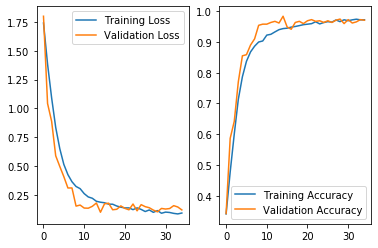

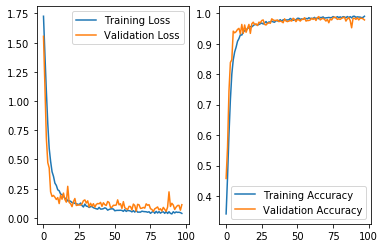

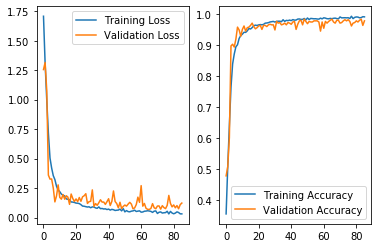

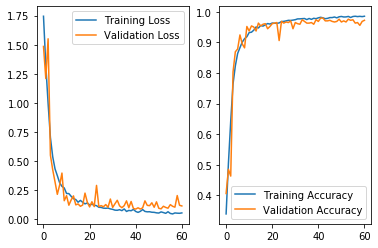

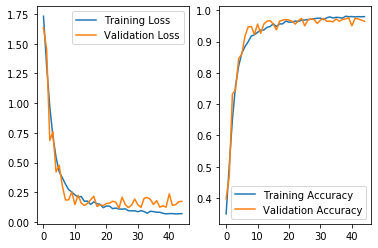

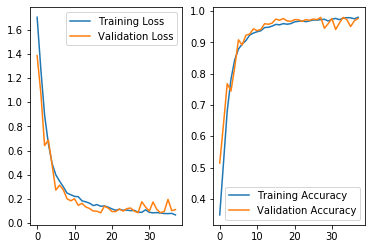

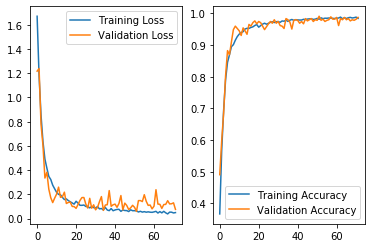

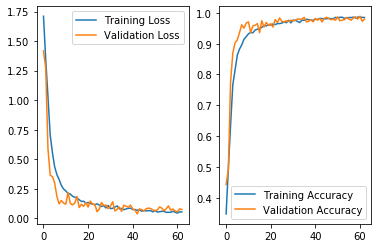

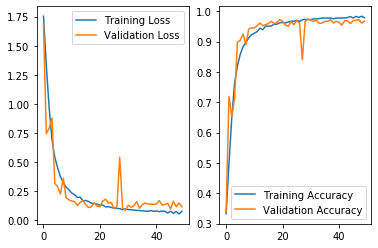

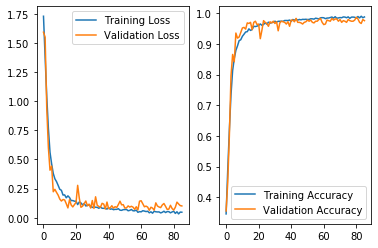

In [23]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [24]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.94373626 0.95313131 0.97086022 0.99217737 0.9777676
 0.88064103 0.96194393]
precision sdev by class [0.         0.06698755 0.06034996 0.03369025 0.00589577 0.02458141
 0.06794625 0.03176327]
macro precision mean 0.9600322148714421
macro precision sdev 0.010712101875857012
recall mean [0.96666667 0.98397436 0.87272727 0.97333333 0.98259144 0.95925926
 0.975      0.98506098]
recall sdev [0.1        0.03208332 0.10123208 0.02       0.0098415  0.03076527
 0.03818813 0.01219893]
macro recall mean 0.9623266637736794
macro recall sdev 0.013712745633948135
f1 mean [0.98       0.96144135 0.90779042 0.97185329 0.98731245 0.96812753
 0.92280806 0.97319358]
f1 sdev [0.06       0.03350968 0.06752077 0.02310579 0.00426461 0.02218344
 0.03109718 0.02073353]
macro f1 mean 0.959065834975903
macro f1 sdev 0.01158936822963539
accuracy mean 0.9754768871972013
accuracy sdev 0.007451878942932315


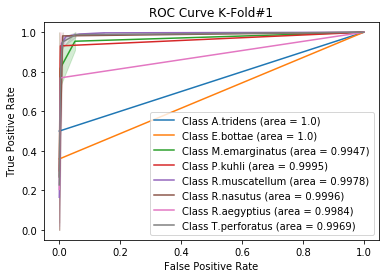

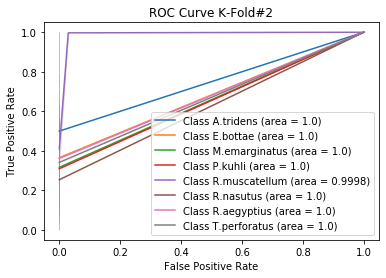

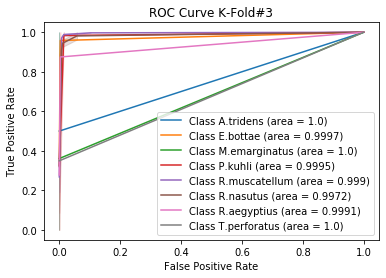

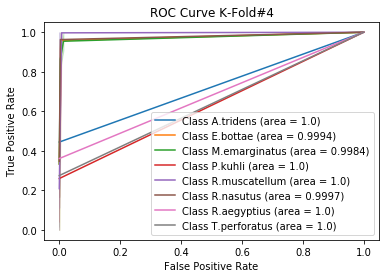

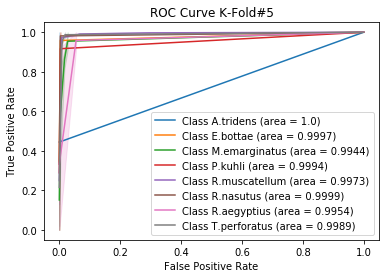

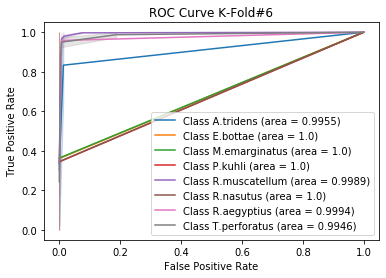

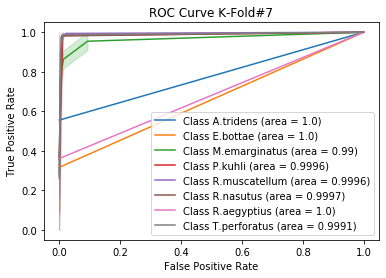

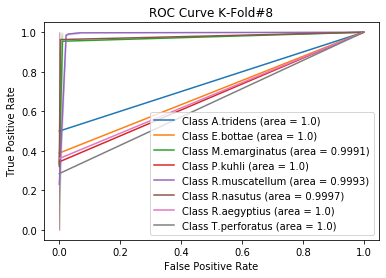

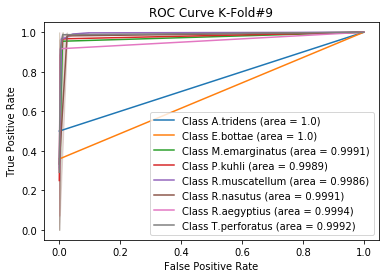

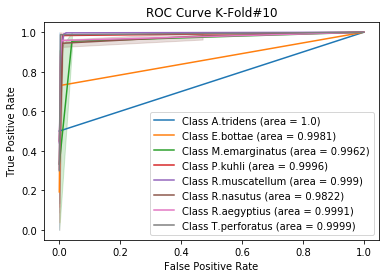

In [25]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [26]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9995540691192865
Std  0.0013377926421404565
Sp:  E.bottae
AUC Mean  0.9996980916592987
Std  0.0005549393621611126
Sp:  M.emarginatus
AUC Mean  0.997186762757328
Std  0.003146010863979141
Sp:  P.kuhli
AUC Mean  0.9996548155120004
Std  0.000342971776871289
Sp:  R.muscatellum
AUC Mean  0.9989345030311061
Std  0.000798294011194386
Sp:  R.nasutus
AUC Mean  0.9977036053970358
Std  0.005243279261465734
Sp:  R.aegyptius
AUC Mean  0.9990926745171466
Std  0.0013270752267444102
Sp:  T.perforatus
AUC Mean  0.9988611359001192
Std  0.001696078058644952


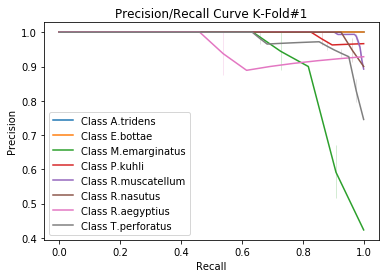

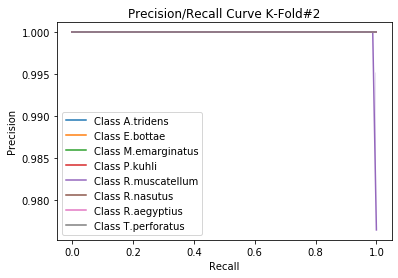

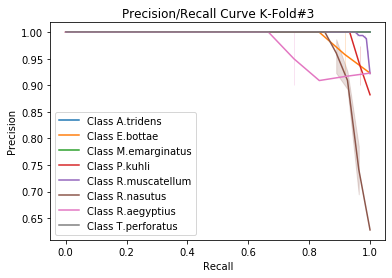

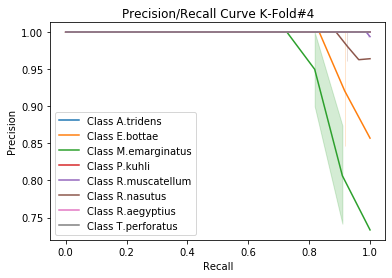

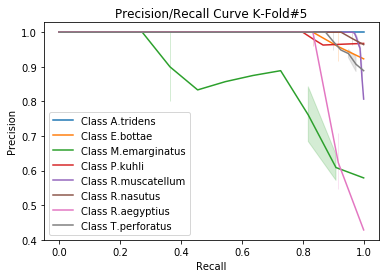

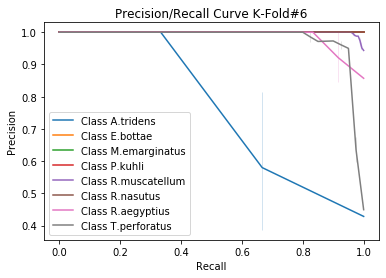

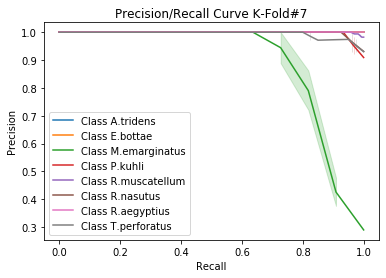

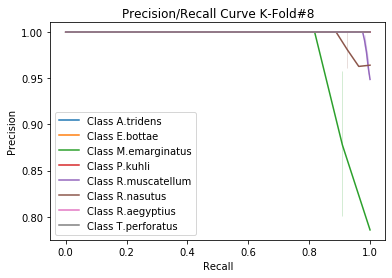

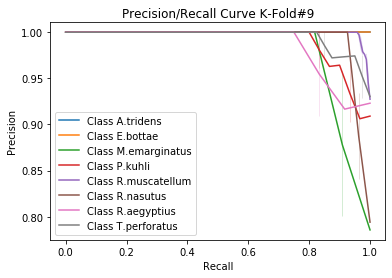

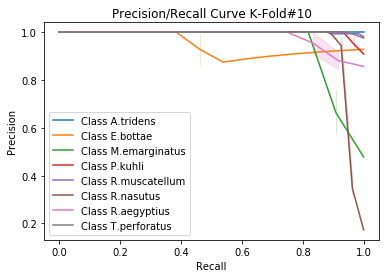

In [27]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1   8   0   0   0   1   1]
 [  0   0   0  29   0   0   0   0]
 [  0   0   1   0 163   0   0   2]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   1   0   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   0   1   0   0]
 [  0   0   0   2 163   0   1   0]
 [  0   0   0   0   1  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

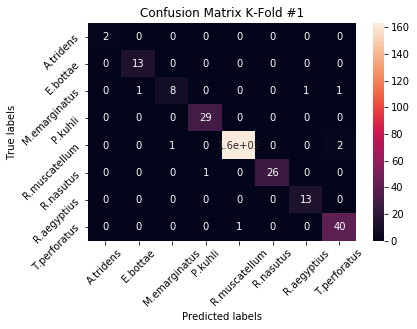

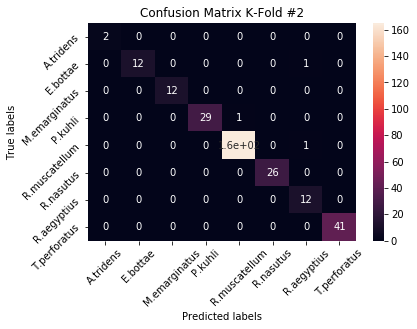

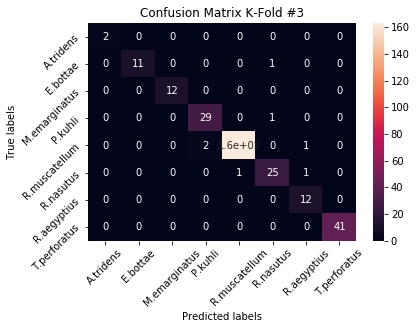

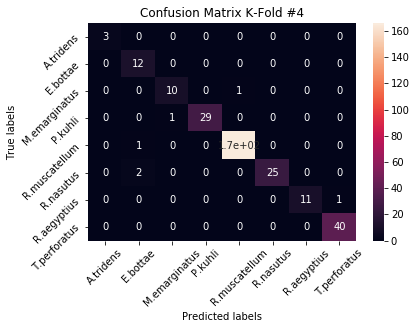

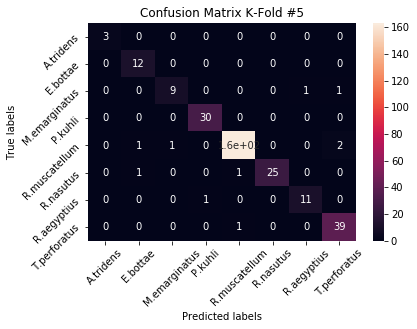

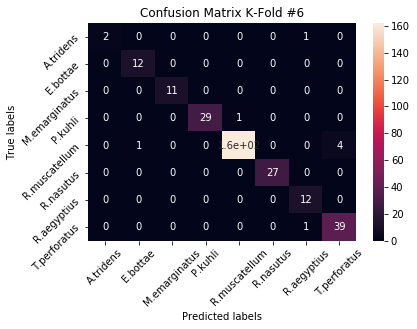

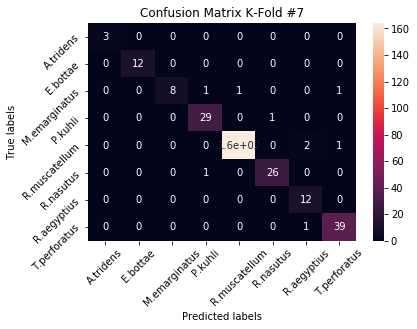

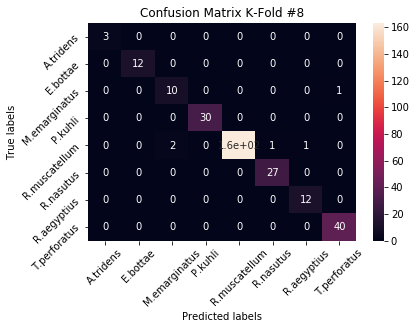

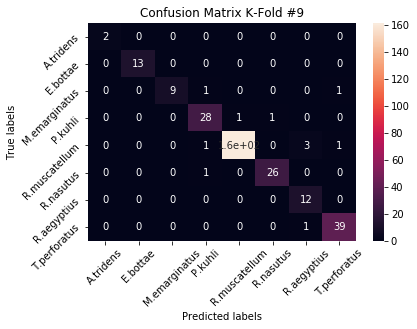

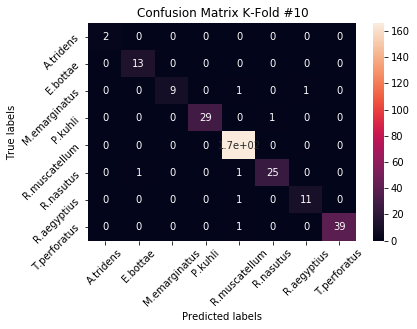

In [28]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  122    0    0    0    1    1    0]
 [   0    1   98    2    3    0    3    5]
 [   0    0    1  291    3    4    0    0]
 [   0    3    4    3 1636    1    8   10]
 [   0    4    0    3    3  258    1    0]
 [   0    0    0    1    1    0  118    1]
 [   0    0    0    0    3    0    3  397]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 163   0   0   1]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


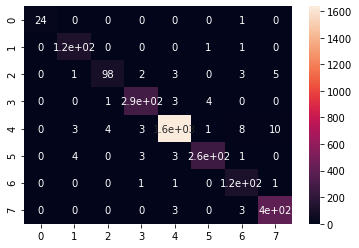

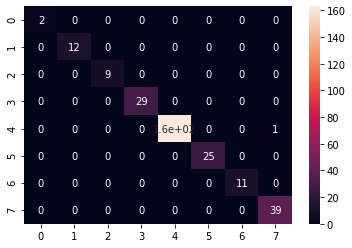

In [29]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.98 0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.01 0.88 0.02 0.03 0.   0.03 0.04]
 [0.   0.   0.   0.97 0.01 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.01 0.   0.01 0.01 0.96 0.   0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.98 0.01]
 [0.   0.   0.   0.   0.01 0.   0.01 0.99]]


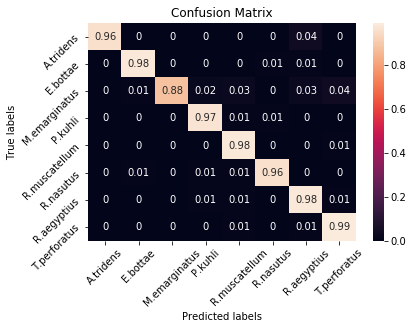

In [30]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V5 !!!!! K-Fold Training and Evaluation</h2>

In [17]:
folder = "models"
mode_version = "mel_smote_v5"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v5


In [18]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [19]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 56)        0         
_________

In [20]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 10s - loss: 1.6607 - acc: 0.3759 - val_loss: 1.3691 - val_acc: 0.4596
Epoch 2/100
9592/9592 - 9s - loss: 1.2956 - acc: 0.5207 - val_loss: 1.0318 - val_acc: 0.6066
Epoch 3/100
9592/9592 - 9s - loss: 1.0028 - acc: 0.6223 - val_loss: 1.0506 - val_acc: 0.5037
Epoch 4/100
9592/9592 - 8s - loss: 0.7679 - acc: 0.7168 - val_loss: 0.6386 - val_acc: 0.7408
Epoch 5/100
9592/9592 - 8s - loss: 0.5537 - acc: 0.8135 - val_loss: 0.3610 - val_acc: 0.8750


Epoch 14/100
9592/9592 - 11s - loss: 0.1165 - acc: 0.9660 - val_loss: 0.1506 - val_acc: 0.9651
Epoch 15/100
9592/9592 - 11s - loss: 0.1183 - acc: 0.9655 - val_loss: 0.2026 - val_acc: 0.9504
Epoch 16/100
9592/9592 - 12s - loss: 0.1043 - acc: 0.9702 - val_loss: 0.1780 - val_acc: 0.9504
Epoch 17/100
9592/9592 - 12s - loss: 0.1043 - acc: 0.9709 - val_loss: 0.1903 - val_acc: 0.9485
Epoch 18/100
9592/9592 - 11s - loss: 0.0850 - acc: 0.9757 - val_loss: 0.1500 - val_acc: 0.9559
Epoch 19/100
9592/9592 - 12s - loss: 0.0806 - acc: 0.9753 - val_loss: 0.1901 - val_acc: 0.9540
Epoch 20/100
9592/9592 - 11s - loss: 0.0972 - acc: 0.9702 - val_loss: 0.1868 - val_acc: 0.9577
Epoch 21/100
9592/9592 - 12s - loss: 0.0707 - acc: 0.9791 - val_loss: 0.1412 - val_acc: 0.9761
Epoch 22/100
9592/9592 - 11s - loss: 0.0705 - acc: 0.9793 - val_loss: 0.1537 - val_acc: 0.9577
Epoch 23/100
9592/9592 - 12s - loss: 0.0643 - acc: 0.9803 - val_loss: 0.2165 - val_acc: 0.9504
Epoch 24/100
9592/9592 - 11s - loss: 0.0737 - acc:

Epoch 46/100
9592/9592 - 9s - loss: 0.0421 - acc: 0.9894 - val_loss: 0.1506 - val_acc: 0.9651
Epoch 47/100
Restoring model weights from the end of the best epoch.
9592/9592 - 9s - loss: 0.0381 - acc: 0.9892 - val_loss: 0.1416 - val_acc: 0.9651
Epoch 00047: early stopping
models/mel_smote_v5_iter_3.model
Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('R.nasutus', 193), ('M.emarginatus', 81), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 112, 170, 3)
Y_train: shape=  (9584, 8)
Train on 9584 samples, validate on 544 samples
Epoch 1/100
9584/9584 - 11s - loss: 1.6491 - acc: 0.3725 - val_loss: 1.4713 - val_acc: 0.4890
Epoch 2/100
9584/9584 - 9s - loss: 1.1920 - acc: 0.5609 - val_loss:

Epoch 34/100
9584/9584 - 9s - loss: 0.0438 - acc: 0.9865 - val_loss: 0.2723 - val_acc: 0.9632
Epoch 35/100
9584/9584 - 9s - loss: 0.0416 - acc: 0.9869 - val_loss: 0.2364 - val_acc: 0.9596
Epoch 36/100
9584/9584 - 9s - loss: 0.0504 - acc: 0.9866 - val_loss: 0.1964 - val_acc: 0.9669
Epoch 37/100
9584/9584 - 9s - loss: 0.0424 - acc: 0.9878 - val_loss: 0.2706 - val_acc: 0.9559
Epoch 38/100
9584/9584 - 9s - loss: 0.0544 - acc: 0.9858 - val_loss: 0.2844 - val_acc: 0.9449
Epoch 39/100
9584/9584 - 9s - loss: 0.0388 - acc: 0.9900 - val_loss: 0.2761 - val_acc: 0.9522
Epoch 40/100
9584/9584 - 9s - loss: 0.0498 - acc: 0.9866 - val_loss: 0.2259 - val_acc: 0.9577
Epoch 41/100
9584/9584 - 9s - loss: 0.0371 - acc: 0.9879 - val_loss: 0.1777 - val_acc: 0.9706
Epoch 42/100
9584/9584 - 9s - loss: 0.0411 - acc: 0.9887 - val_loss: 0.2191 - val_acc: 0.9688
Epoch 43/100
9584/9584 - 10s - loss: 0.0369 - acc: 0.9899 - val_loss: 0.2090 - val_acc: 0.9669
Epoch 44/100
9584/9584 - 9s - loss: 0.0481 - acc: 0.9861 - 

Epoch 8/100
9584/9584 - 9s - loss: 0.2299 - acc: 0.9303 - val_loss: 0.2620 - val_acc: 0.9412
Epoch 9/100
9584/9584 - 10s - loss: 0.1958 - acc: 0.9416 - val_loss: 0.1621 - val_acc: 0.9522
Epoch 10/100
9584/9584 - 9s - loss: 0.1837 - acc: 0.9426 - val_loss: 0.1027 - val_acc: 0.9651
Epoch 11/100
9584/9584 - 10s - loss: 0.1541 - acc: 0.9537 - val_loss: 0.1766 - val_acc: 0.9449
Epoch 12/100
9584/9584 - 10s - loss: 0.1214 - acc: 0.9647 - val_loss: 0.1458 - val_acc: 0.9614
Epoch 13/100
9584/9584 - 10s - loss: 0.1396 - acc: 0.9596 - val_loss: 0.1943 - val_acc: 0.9522
Epoch 14/100
9584/9584 - 9s - loss: 0.1078 - acc: 0.9674 - val_loss: 0.1406 - val_acc: 0.9577
Epoch 15/100
9584/9584 - 10s - loss: 0.1210 - acc: 0.9658 - val_loss: 0.1173 - val_acc: 0.9743
Epoch 16/100
9584/9584 - 10s - loss: 0.1080 - acc: 0.9673 - val_loss: 0.1932 - val_acc: 0.9412
Epoch 17/100
9584/9584 - 10s - loss: 0.1101 - acc: 0.9664 - val_loss: 0.1597 - val_acc: 0.9669
Epoch 18/100
9584/9584 - 10s - loss: 0.0894 - acc: 0.97

X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 12s - loss: 1.6660 - acc: 0.3724 - val_loss: 1.4820 - val_acc: 0.3989
Epoch 2/100
9592/9592 - 10s - loss: 1.2385 - acc: 0.5384 - val_loss: 0.9347 - val_acc: 0.6213
Epoch 3/100
9592/9592 - 10s - loss: 0.8934 - acc: 0.6653 - val_loss: 0.9163 - val_acc: 0.6342
Epoch 4/100
9592/9592 - 10s - loss: 0.6180 - acc: 0.7907 - val_loss: 0.3237 - val_acc: 0.8934
Epoch 5/100
9592/9592 - 10s - loss: 0.4339 - acc: 0.8578 - val_loss: 0.2598 - val_acc: 0.9136
Epoch 6/100
9592/9592 - 9s - loss: 0.3347 - acc: 0.8902 - val_loss: 0.2332 - val_acc: 0.9246
Epoch 7/100
9592/9592 - 10s - loss: 0.2639 - acc: 0.9176 - val_loss: 0.3451 - val_acc: 0.8952
Epoch 8/100
9592/9592 - 10s - loss: 0.2327 - acc: 0.9287 - val_loss: 0.1542 - val_acc: 0.9485
Epoch 9/100
9592/9592 - 10s - loss: 0.2083 - acc: 0.9387 - val_loss: 0.1893 - val_acc: 0.9412
Epoch 10/100
9592/9592 - 10s - loss: 0.1727 

Epoch 29/100
9592/9592 - 9s - loss: 0.0598 - acc: 0.9805 - val_loss: 0.1154 - val_acc: 0.9669
Epoch 30/100
9592/9592 - 10s - loss: 0.0562 - acc: 0.9840 - val_loss: 0.1429 - val_acc: 0.9614
Epoch 31/100
9592/9592 - 9s - loss: 0.0545 - acc: 0.9847 - val_loss: 0.1458 - val_acc: 0.9614
Epoch 32/100
9592/9592 - 9s - loss: 0.0566 - acc: 0.9842 - val_loss: 0.1795 - val_acc: 0.9540
Epoch 33/100
9592/9592 - 9s - loss: 0.0585 - acc: 0.9831 - val_loss: 0.1013 - val_acc: 0.9706
Epoch 34/100
9592/9592 - 9s - loss: 0.0453 - acc: 0.9857 - val_loss: 0.1437 - val_acc: 0.9724
Epoch 35/100
9592/9592 - 9s - loss: 0.0550 - acc: 0.9838 - val_loss: 0.1351 - val_acc: 0.9706
Epoch 36/100
9592/9592 - 9s - loss: 0.0469 - acc: 0.9855 - val_loss: 0.1608 - val_acc: 0.9706
Epoch 37/100
9592/9592 - 10s - loss: 0.0525 - acc: 0.9860 - val_loss: 0.1116 - val_acc: 0.9706
Epoch 38/100
9592/9592 - 10s - loss: 0.0525 - acc: 0.9849 - val_loss: 0.1517 - val_acc: 0.9596
Epoch 39/100
9592/9592 - 9s - loss: 0.0346 - acc: 0.9899 

In [21]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_smote_v5_iter_1.model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
File Name Loaded:  models/mel_smote_v5_iter_2.model
File Name Loaded:  models/mel_smote_v5_iter_3.model
File Name Loaded:  models/mel_smote_v5_iter_4.model
File Name Loaded:  models/mel_smote_v5_iter_5.model
File Name Loaded:  models/mel_smote_v5_iter_6.model
File Name Loaded:  models/mel_smote_v5_iter_7.model
File Name Loaded:  models/mel_smote_v5_iter_8.model
File Name Loaded:  models/mel_smote_v5_iter_9.model
File Name Loaded:  models/mel_smote_v5_iter_10.model


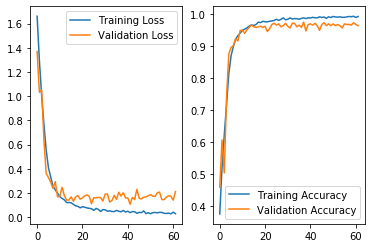

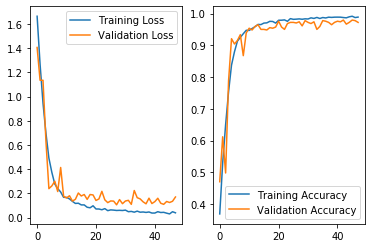

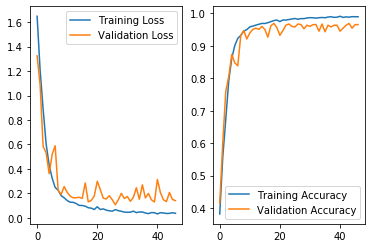

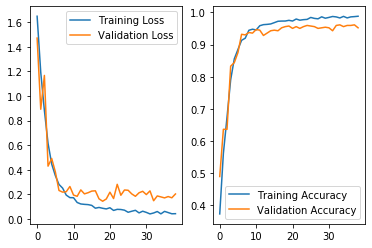

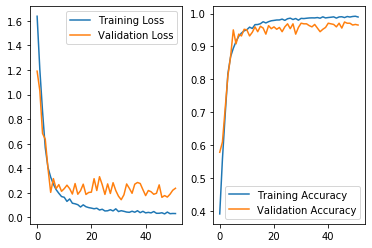

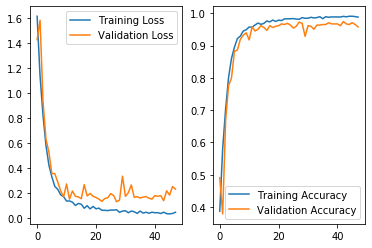

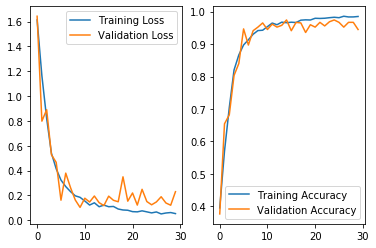

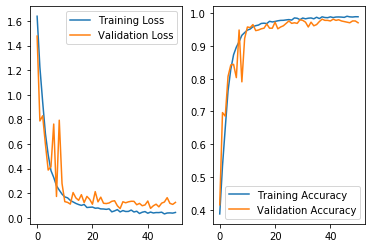

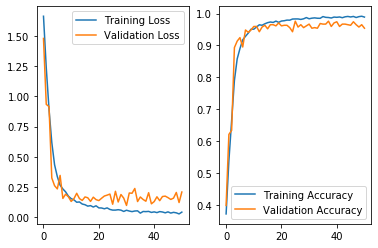

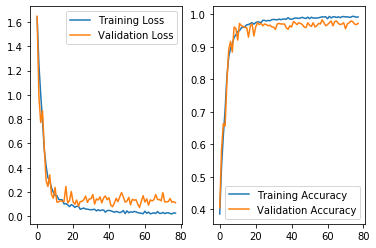

In [22]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [23]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.93373626 0.89691087 0.97094086 0.9792828  0.97392145
 0.88406593 0.96311934]
precision sdev by class [0.         0.05872932 0.09554381 0.04396858 0.01387827 0.03339252
 0.04707744 0.0307372 ]
macro precision mean 0.9502471890096865
macro precision sdev 0.01747663273060309
recall mean [1.         0.94423077 0.85454545 0.95321839 0.98558546 0.94430199
 0.93333333 0.95536585]
recall sdev [0.         0.05023367 0.09270945 0.03707872 0.00770011 0.02977481
 0.05       0.03078248]
macro recall mean 0.94632265643369
macro recall sdev 0.020803177427901557
f1 mean [1.         0.93702474 0.8714961  0.96143581 0.98236402 0.95861957
 0.90721937 0.95881522]
f1 sdev [0.         0.03468603 0.07423568 0.03365876 0.00823829 0.02718018
 0.04053474 0.02368782]
macro f1 mean 0.9471218540576072
macro f1 sdev 0.016736907162207715
accuracy mean 0.9661943631603265
accuracy sdev 0.011197913867681139


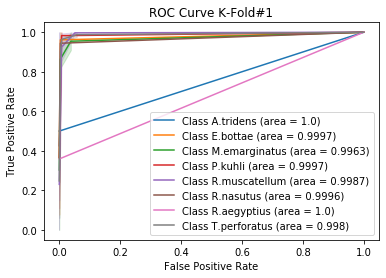

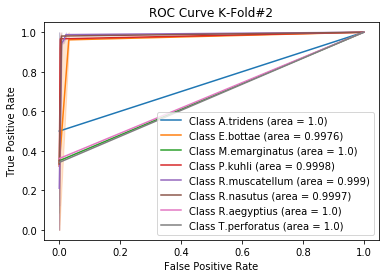

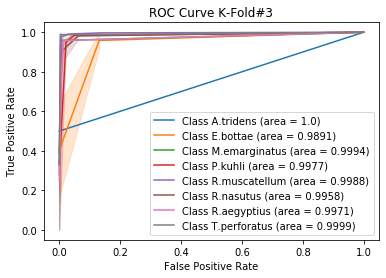

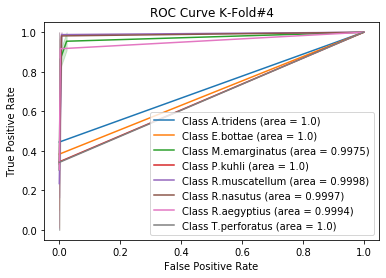

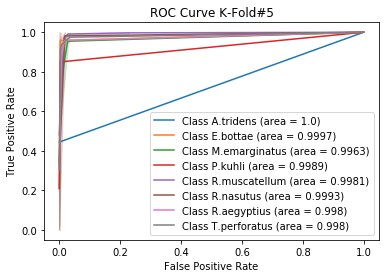

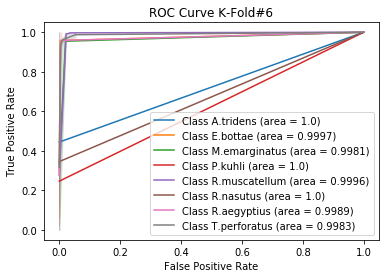

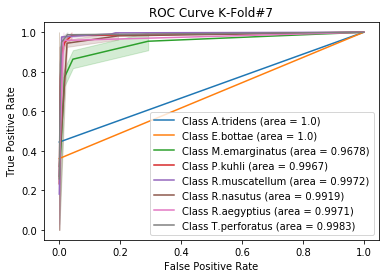

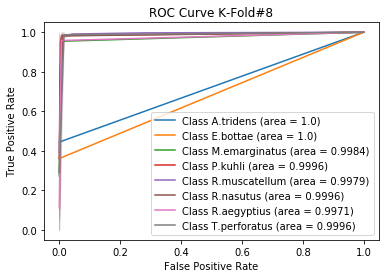

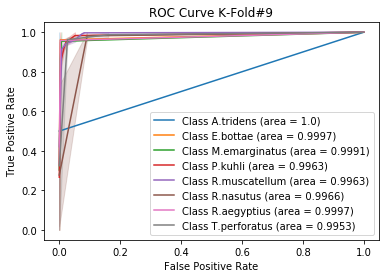

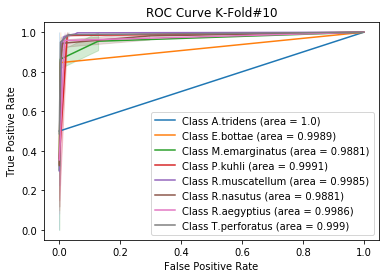

In [24]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [25]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9984508578877538
Std  0.0032003947002581285
Sp:  M.emarginatus
AUC Mean  0.9940961876137846
Std  0.009328775951059139
Sp:  P.kuhli
AUC Mean  0.9987843392370799
Std  0.0013200317057203495
Sp:  R.muscatellum
AUC Mean  0.998391683441527
Std  0.0010235506701441544
Sp:  R.nasutus
AUC Mean  0.9970440160706742
Std  0.003862586610550892
Sp:  R.aegyptius
AUC Mean  0.9985913574354692
Std  0.0011308730478903168
Sp:  T.perforatus
AUC Mean  0.9986472165689018
Std  0.0013626047012741164


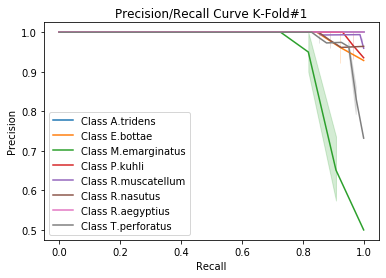

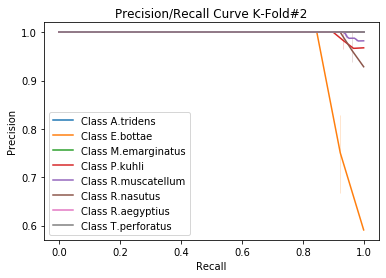

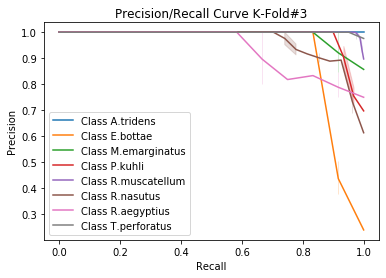

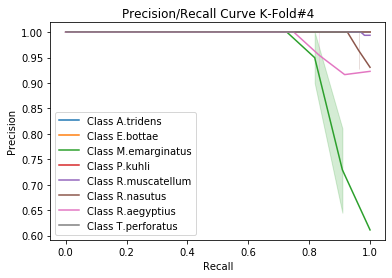

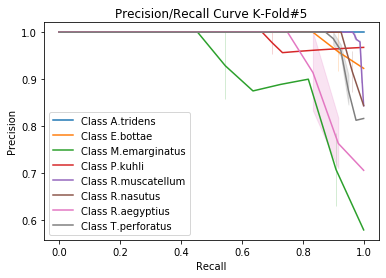

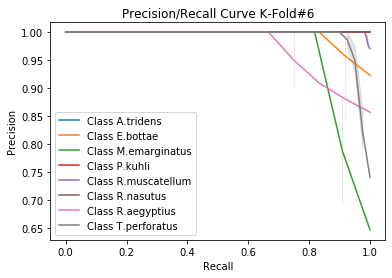

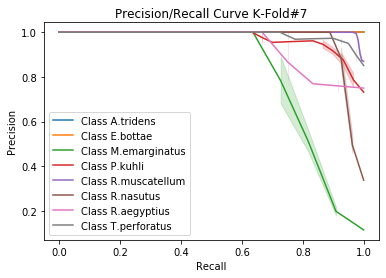

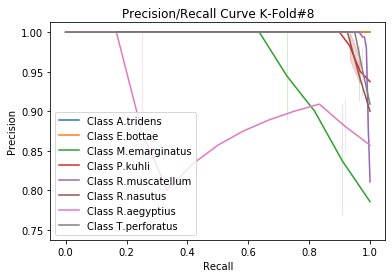

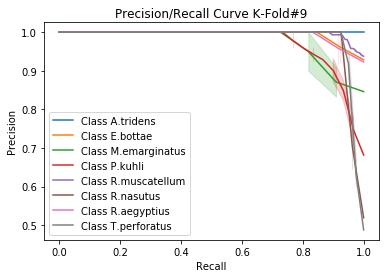

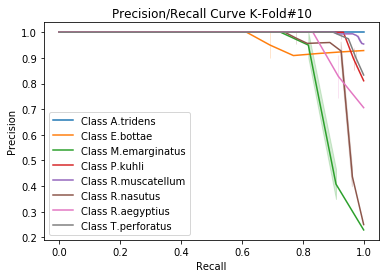

In [26]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1   9   0   0   0   1   0]
 [  0   0   0  28   0   1   0   0]
 [  0   0   0   0 165   0   0   1]
 [  0   0   0   0   0  27   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   1   1   0   2   0   0  37]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   1   0   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   1   0  27   2   0   0   0]
 [  0   1   1   0 163   0   1   0]
 [  0   0   0   0   0  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  28   0   2   0   0]
 [  0   0   1   0 164   0   1   0]
 [  0   0   1   0   1  24   1   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

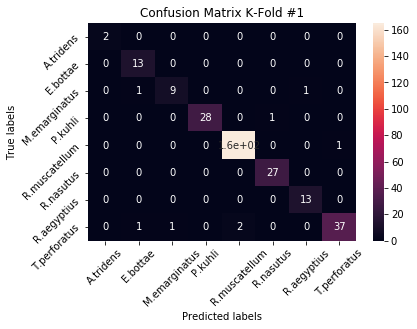

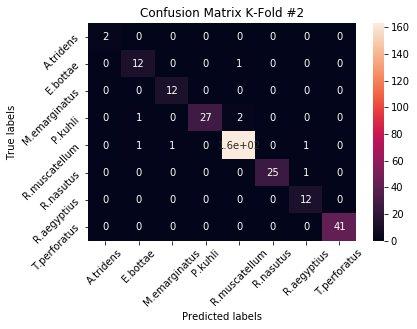

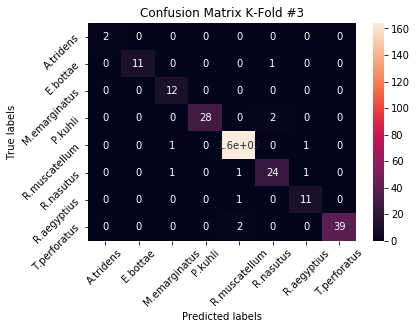

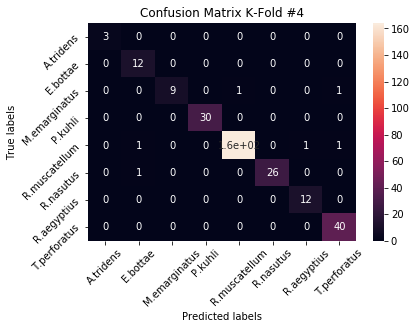

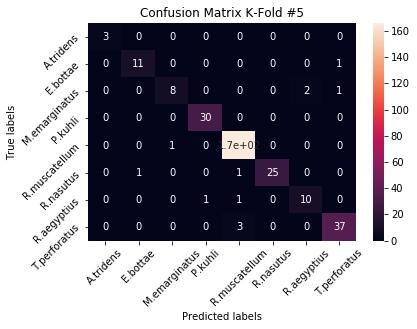

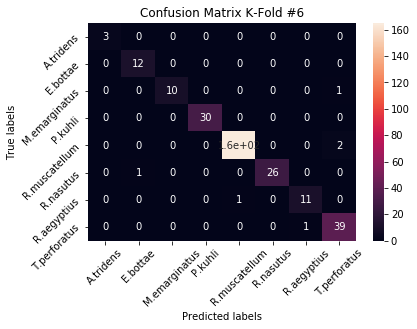

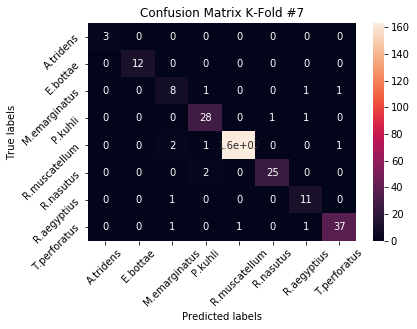

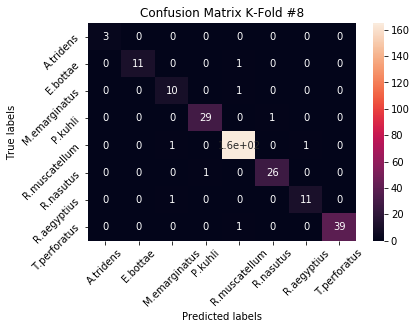

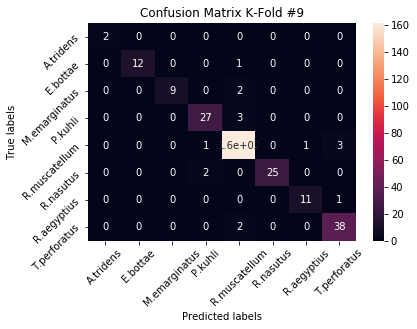

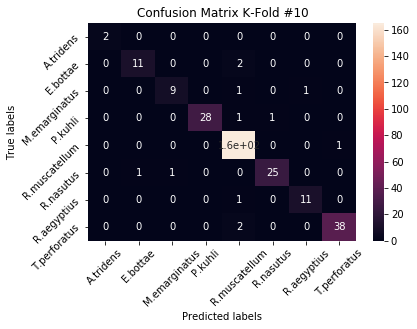

In [27]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  25    0    0    0    0    0    0    0]
 [   0  117    0    0    5    1    0    1]
 [   0    1   96    1    5    0    5    4]
 [   0    1    0  285    6    6    1    0]
 [   0    2    6    2 1641    0    5    9]
 [   0    4    2    5    2  254    2    0]
 [   0    0    2    1    4    0  113    1]
 [   0    1    2    0   13    0    2  385]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


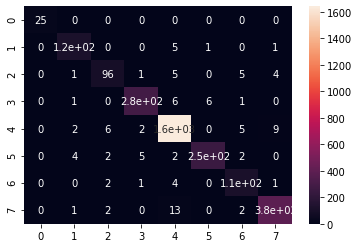

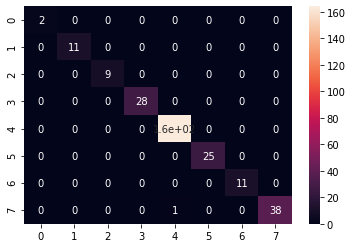

In [28]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.94 0.   0.   0.04 0.01 0.   0.01]
 [0.   0.01 0.86 0.01 0.04 0.   0.04 0.04]
 [0.   0.   0.   0.95 0.02 0.02 0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.01]
 [0.   0.01 0.01 0.02 0.01 0.94 0.01 0.  ]
 [0.   0.   0.02 0.01 0.03 0.   0.93 0.01]
 [0.   0.   0.   0.   0.03 0.   0.   0.96]]


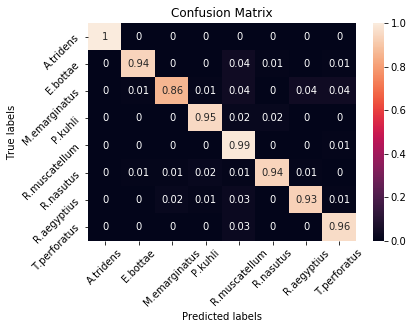

In [29]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

# V6 Re-Load Data

In [30]:
folder = "models"
mode_version = "mel_smote_v6"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v6


In [31]:
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((85, 56))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [32]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 56, 85, 3)
(3018,)


In [33]:
def build_current_model():
    inp = Input(shape=(56,85,3))
    lay = Convolution2D(filters=48,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [34]:
model = build_current_model()
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 56, 85, 3)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 43, 48)        7104      
_________________________________________________________________
batch_normalization_77 (Batc (None, 28, 43, 48)        192       
_________________________________________________________________
activation_77 (Activation)   (None, 28, 43, 48)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 22, 48)        0         
_________________________________________________________________
spatial_dropout2d_44 (Spatia (None, 14, 22, 48)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 11, 32)         384

In [35]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 56, 85, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 15s - loss: 1.3205 - acc: 0.5082 - val_loss: 0.8501 - val_acc: 0.6801
Epoch 2/100
9592/9592 - 10s - loss: 0.6863 - acc: 0.7581 - val_loss: 0.4608 - val_acc: 0.8290
Epoch 3/100
9592/9592 - 11s - loss: 0.4431 - acc: 0.8451 - val_loss: 0.4154 - val_acc: 0.8474
Epoch 4/100
9592/9592 - 12s - loss: 0.3259 - acc: 0.8914 - val_loss: 0.3801 - val_acc: 0.8658
Epoch 5/100
9592/9592 - 11s - loss: 0.2655 - acc: 0.9133 - val_loss: 0.3742 - val_acc: 0.858

Epoch 11/100
9592/9592 - 9s - loss: 0.1113 - acc: 0.9659 - val_loss: 0.2926 - val_acc: 0.8805
Epoch 12/100
9592/9592 - 8s - loss: 0.0955 - acc: 0.9683 - val_loss: 0.1260 - val_acc: 0.9688
Epoch 13/100
9592/9592 - 10s - loss: 0.0963 - acc: 0.9691 - val_loss: 0.1499 - val_acc: 0.9596
Epoch 14/100
9592/9592 - 10s - loss: 0.0799 - acc: 0.9758 - val_loss: 0.1174 - val_acc: 0.9651
Epoch 15/100
9592/9592 - 9s - loss: 0.0794 - acc: 0.9758 - val_loss: 0.1280 - val_acc: 0.9669
Epoch 16/100
9592/9592 - 9s - loss: 0.0762 - acc: 0.9776 - val_loss: 0.2031 - val_acc: 0.9338
Epoch 17/100
9592/9592 - 9s - loss: 0.0712 - acc: 0.9790 - val_loss: 0.1396 - val_acc: 0.9504
Epoch 18/100
9592/9592 - 10s - loss: 0.0660 - acc: 0.9820 - val_loss: 0.1811 - val_acc: 0.9504
Epoch 19/100
9592/9592 - 9s - loss: 0.0694 - acc: 0.9788 - val_loss: 0.1363 - val_acc: 0.9559
Epoch 20/100
9592/9592 - 9s - loss: 0.0659 - acc: 0.9811 - val_loss: 0.2125 - val_acc: 0.9467
Epoch 21/100
9592/9592 - 8s - loss: 0.0574 - acc: 0.9822 

Epoch 42/100
9592/9592 - 9s - loss: 0.0256 - acc: 0.9925 - val_loss: 0.2097 - val_acc: 0.9596
Epoch 43/100
9592/9592 - 8s - loss: 0.0310 - acc: 0.9897 - val_loss: 0.1906 - val_acc: 0.9504
Epoch 44/100
9592/9592 - 9s - loss: 0.0273 - acc: 0.9910 - val_loss: 0.1705 - val_acc: 0.9577
Epoch 45/100
9592/9592 - 10s - loss: 0.0350 - acc: 0.9892 - val_loss: 0.2059 - val_acc: 0.9540
Epoch 46/100
9592/9592 - 8s - loss: 0.0352 - acc: 0.9900 - val_loss: 0.2682 - val_acc: 0.9577
Epoch 47/100
9592/9592 - 9s - loss: 0.0105 - acc: 0.9964 - val_loss: 0.3488 - val_acc: 0.9449
Epoch 48/100
9592/9592 - 9s - loss: 0.0316 - acc: 0.9908 - val_loss: 0.2684 - val_acc: 0.9559
Epoch 49/100
9592/9592 - 9s - loss: 0.0331 - acc: 0.9904 - val_loss: 0.2012 - val_acc: 0.9614
Epoch 50/100
9592/9592 - 9s - loss: 0.0229 - acc: 0.9934 - val_loss: 0.2119 - val_acc: 0.9577
Epoch 51/100
9592/9592 - 8s - loss: 0.0349 - acc: 0.9904 - val_loss: 0.2049 - val_acc: 0.9577
Epoch 52/100
9592/9592 - 9s - loss: 0.0260 - acc: 0.9916 - 

Epoch 67/100
9584/9584 - 10s - loss: 0.0204 - acc: 0.9937 - val_loss: 0.2298 - val_acc: 0.9504
Epoch 68/100
Restoring model weights from the end of the best epoch.
9584/9584 - 11s - loss: 0.0258 - acc: 0.9922 - val_loss: 0.1931 - val_acc: 0.9651
Epoch 00068: early stopping
models/mel_smote_v6_iter_4.model
Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('R.nasutus', 193), ('M.emarginatus', 81), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 56, 85, 3)
Y_train: shape=  (9584, 8)
Train on 9584 samples, validate on 544 samples
Epoch 1/100
9584/9584 - 14s - loss: 1.3771 - acc: 0.4897 - val_loss: 0.7679 - val_acc: 0.7059
Epoch 2/100
9584/9584 - 11s - loss: 0.6720 - acc: 0.7678 - val_loss

Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 56, 85, 3)
Y_train: shape=  (9584, 8)
Train on 9584 samples, validate on 544 samples
Epoch 1/100
9584/9584 - 14s - loss: 1.3304 - acc: 0.5073 - val_loss: 0.8726 - val_acc: 0.6452
Epoch 2/100
9584/9584 - 12s - loss: 0.6604 - acc: 0.7703 - val_loss: 0.7791 - val_acc: 0.6893
Epoch 3/100
9584/9584 - 12s - loss: 0.4437 - acc: 0.8513 - val_loss: 0.3690 - val_acc: 0.8860
Epoch 4/100
9584/9584 - 12s - loss: 0.3297 - acc: 0.8897 - val_loss: 0.3188 - val_acc: 0.9136
Epoch 5/100
9584/9584 - 11s - loss: 0.2481 - acc: 0.9199 - val_loss: 0.4113 - val_acc: 0.8621
Epoch 6/100
9584/9584 - 11s - loss: 0.2005 - acc: 0.9345 - val_loss: 0.4672 - val_acc: 0.8640
Epoch 7/100
9584/9584 - 12s - loss: 0.1697 - acc: 0.9467 - val_loss: 0.3205 - val_acc: 0.9081
Epoch 

Epoch 5/100
9584/9584 - 8s - loss: 0.2809 - acc: 0.9068 - val_loss: 0.2992 - val_acc: 0.8934
Epoch 6/100
9584/9584 - 8s - loss: 0.2176 - acc: 0.9300 - val_loss: 0.1588 - val_acc: 0.9357
Epoch 7/100
9584/9584 - 9s - loss: 0.1844 - acc: 0.9414 - val_loss: 0.1799 - val_acc: 0.9393
Epoch 8/100
9584/9584 - 9s - loss: 0.1598 - acc: 0.9502 - val_loss: 0.3961 - val_acc: 0.8879
Epoch 9/100
9584/9584 - 10s - loss: 0.1381 - acc: 0.9561 - val_loss: 0.2012 - val_acc: 0.9375
Epoch 10/100
9584/9584 - 9s - loss: 0.1379 - acc: 0.9546 - val_loss: 0.2371 - val_acc: 0.9210
Epoch 11/100
9584/9584 - 10s - loss: 0.1157 - acc: 0.9615 - val_loss: 0.1686 - val_acc: 0.9412
Epoch 12/100
9584/9584 - 9s - loss: 0.0967 - acc: 0.9691 - val_loss: 0.1688 - val_acc: 0.9504
Epoch 13/100
9584/9584 - 9s - loss: 0.0988 - acc: 0.9692 - val_loss: 0.1063 - val_acc: 0.9632
Epoch 14/100
9584/9584 - 8s - loss: 0.0836 - acc: 0.9734 - val_loss: 0.2650 - val_acc: 0.9210
Epoch 15/100
9584/9584 - 9s - loss: 0.0918 - acc: 0.9712 - val_

Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1199), ('P.kuhli', 215), ('M.emarginatus', 81), ('R.aegyptius', 87), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.aegyptius', 1199), ('R.nasutus', 1199), ('E.bottae', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 56, 85, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 14s - loss: 1.4140 - acc: 0.4738 - val_loss: 1.0120 - val_acc: 0.6636
Epoch 2/100
9592/9592 - 12s - loss: 0.7201 - acc: 0.7445 - val_loss: 0.7181 - val_acc: 0.7132
Epoch 3/100
9592/9592 - 11s - loss: 0.4516 - acc: 0.8431 - val_loss: 0.5203 - val_acc: 0.7794
Epoch 4/100
9592/9592 - 11s - loss: 0.3144 - acc: 0.8987 - val_loss: 0.4355 - val_acc: 0.8511
Epoch 5/100
9592/9592 - 10s - loss: 0.2494 - acc: 0.9191 - val_loss: 0.3475 - val_acc: 0.887

In [36]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/mel_smote_v6_iter_1.model
File Name Loaded:  models/mel_smote_v6_iter_2.model
File Name Loaded:  models/mel_smote_v6_iter_3.model
File Name Loaded:  models/mel_smote_v6_iter_4.model
File Name Loaded:  models/mel_smote_v6_iter_5.model
File Name Loaded:  models/mel_smote_v6_iter_6.model
File Name Loaded:  models/mel_smote_v6_iter_7.model
File Name Loaded:  models/mel_smote_v6_iter_8.model
File Name Loaded:  models/mel_smote_v6_iter_9.model
File Name Loaded:  models/mel_smote_v6_iter_10.model


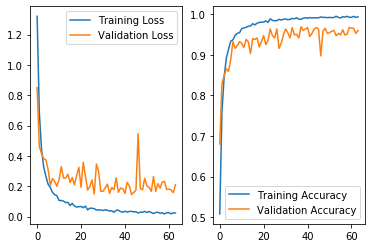

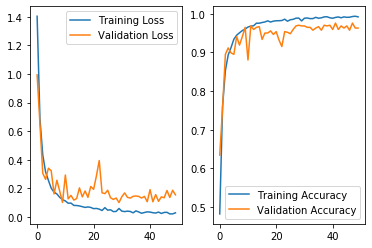

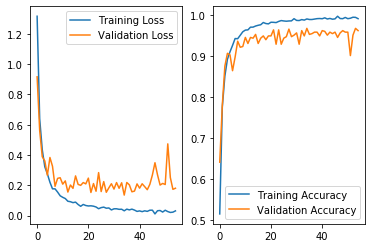

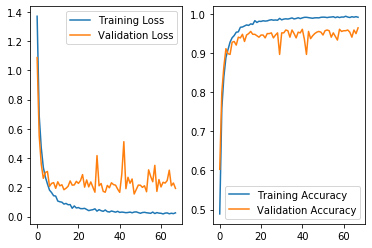

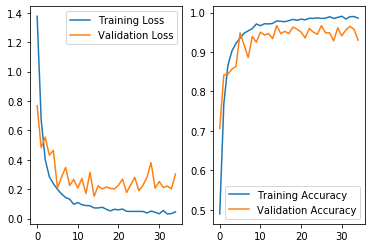

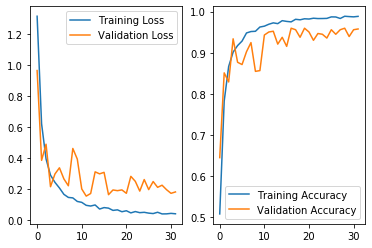

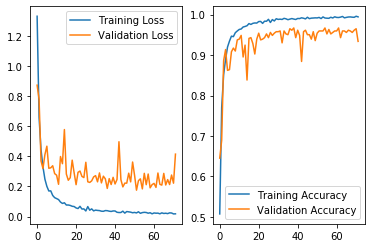

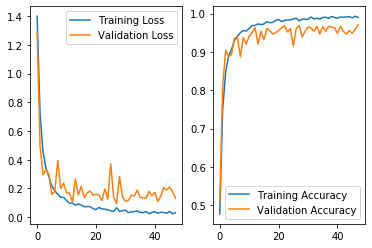

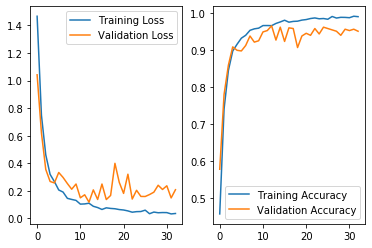

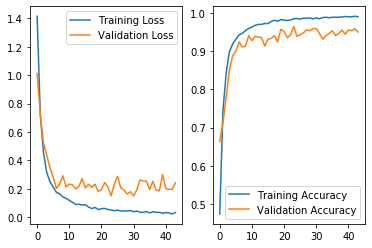

In [37]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [38]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.91748876 0.93079254 0.94668282 0.98146456 0.96961498
 0.80086296 0.95392383]
precision sdev by class [0.         0.08371508 0.08397781 0.02605467 0.00932828 0.02842386
 0.07557892 0.03226796]
macro precision mean 0.937603807257989
macro precision sdev 0.018567814321393435
recall mean [0.93333333 0.96025641 0.81893939 0.94666667 0.98079143 0.93319088
 0.93397436 0.94518293]
recall sdev [0.2        0.06447329 0.10030086 0.04521553 0.00444936 0.04309652
 0.06221913 0.04006283]
macro recall mean 0.9315419252975161
macro recall sdev 0.02803457981013126
f1 mean [0.95       0.93430034 0.86489693 0.94619383 0.98109683 0.95048488
 0.85951564 0.9487317 ]
f1 sdev [0.15       0.04756058 0.06184887 0.0303479  0.00477105 0.02882146
 0.04862601 0.02503938]
macro f1 mean 0.9294025195259937
macro f1 sdev 0.02665123841648928
accuracy mean 0.9592385206046071
accuracy sdev 0.010813957684434107


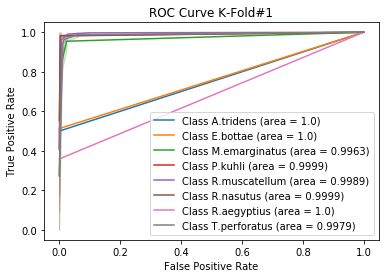

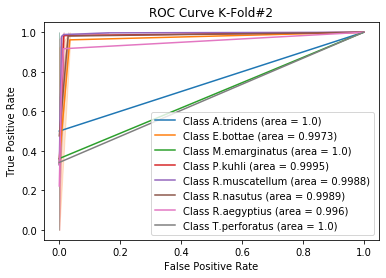

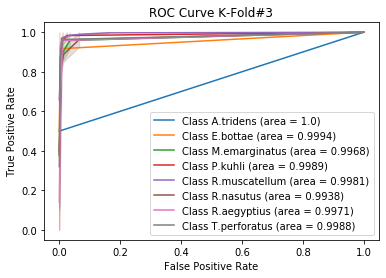

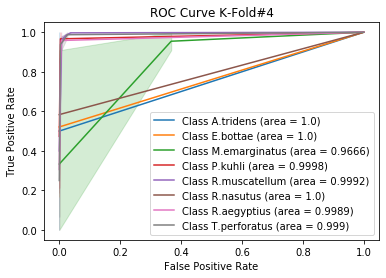

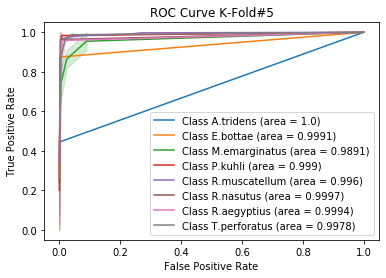

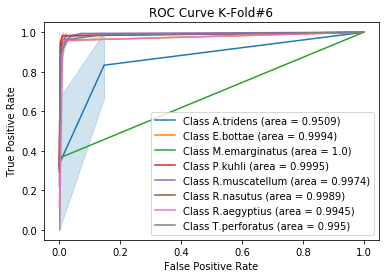

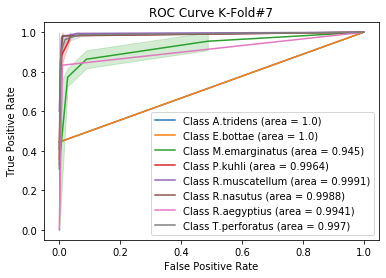

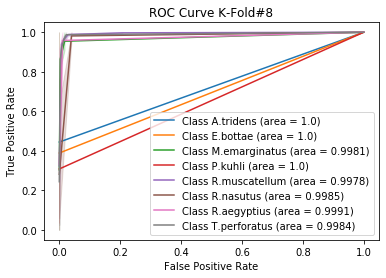

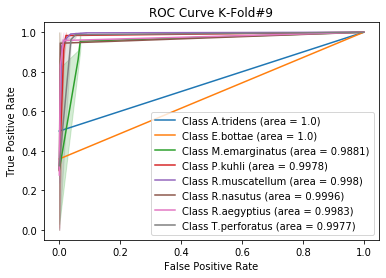

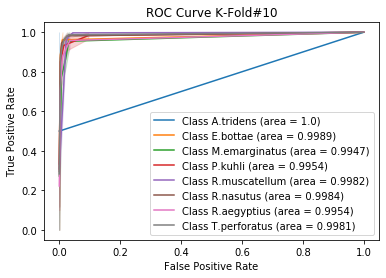

In [39]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [40]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9950947603121516
Std  0.014715719063545152
Sp:  E.bottae
AUC Mean  0.9994258431515322
Std  0.0007958175555468881
Sp:  M.emarginatus
AUC Mean  0.9874630503398721
Std  0.016988645808304496
Sp:  P.kuhli
AUC Mean  0.9986245876780148
Std  0.0014852924638415676
Sp:  R.muscatellum
AUC Mean  0.9981486733203411
Std  0.0009045937462850672
Sp:  R.nasutus
AUC Mean  0.9986487227407569
Std  0.001705169426015929
Sp:  R.aegyptius
AUC Mean  0.9972822952710496
Std  0.0020436872186684525
Sp:  T.perforatus
AUC Mean  0.997973042934562
Std  0.0012526987271391087


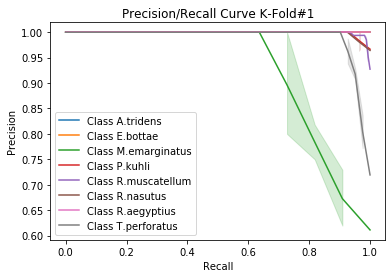

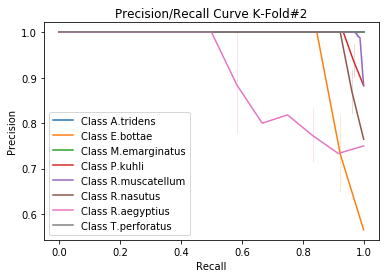

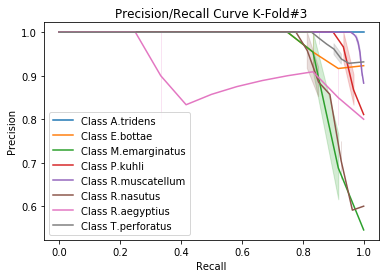

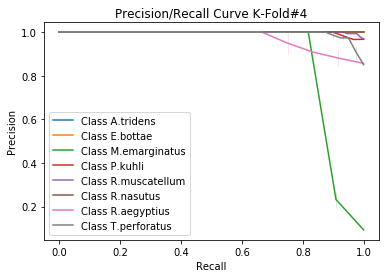

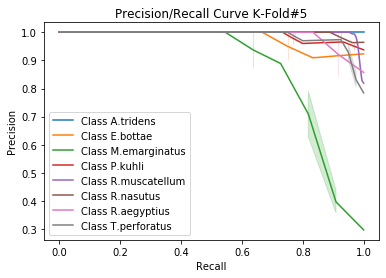

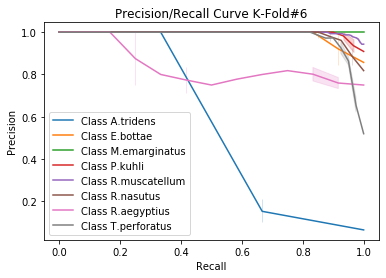

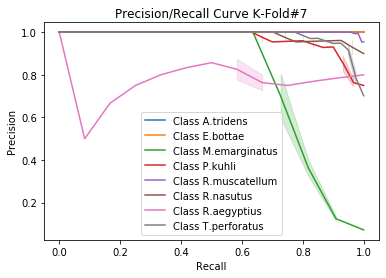

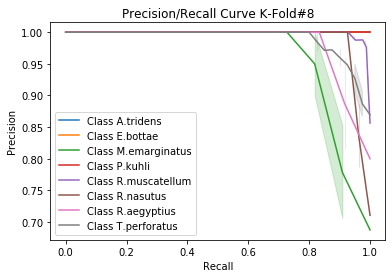

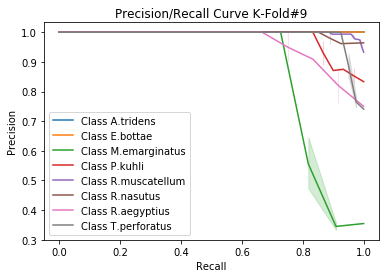

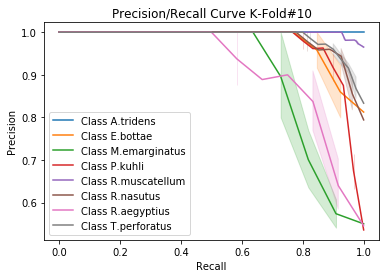

In [41]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   7   0   1   0   0   3]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   1 164   0   0   1]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  12   1]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   0   1   0   0]
 [  0   0   0   2 163   0   1   0]
 [  0   0   0   0   0  25   1   0]
 [  0   0   1   0   1   0  10   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   0   1]
 [  0   0  11   0   0   0   1   0]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   0 163   0   1   2]
 [  0   1   0   1   1  23   1   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   1   0   1   0   0  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

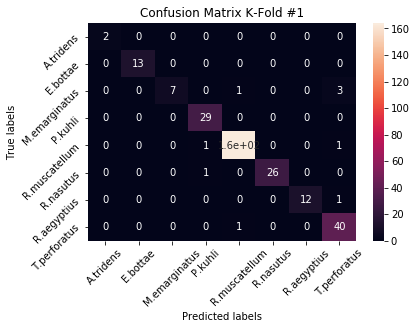

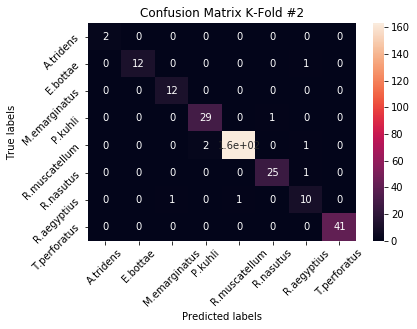

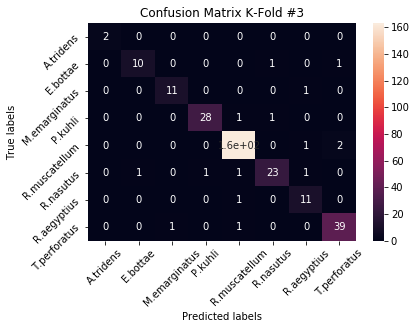

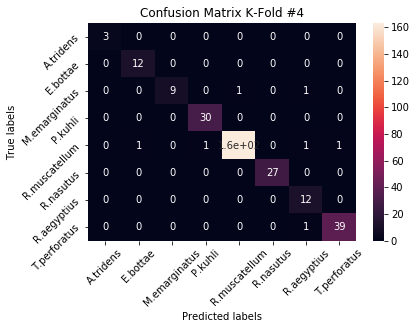

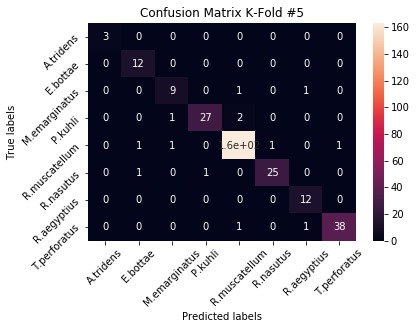

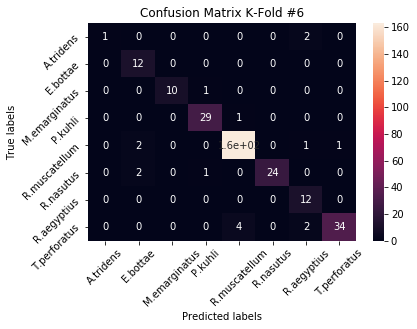

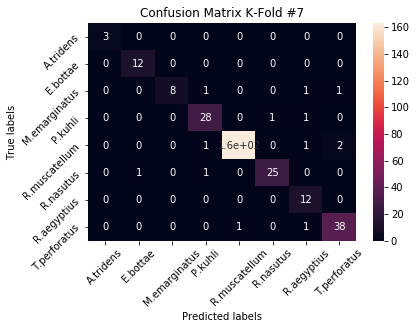

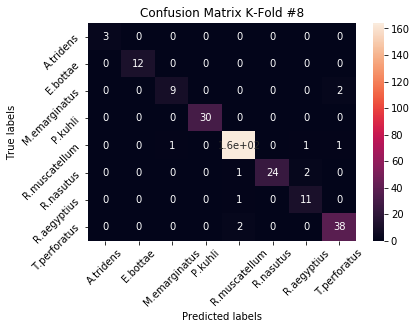

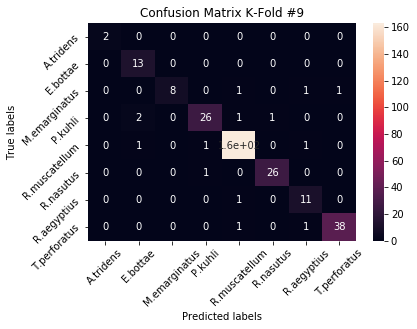

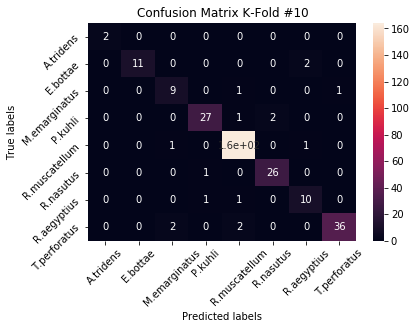

In [42]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  119    0    0    0    1    3    1]
 [   0    0   92    2    5    0    5    8]
 [   0    2    1  283    6    6    1    0]
 [   0    5    3    6 1633    1    8    9]
 [   0    5    0    7    2  251    4    0]
 [   0    0    1    1    5    0  113    1]
 [   0    0    3    0   13    0    6  381]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 163   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


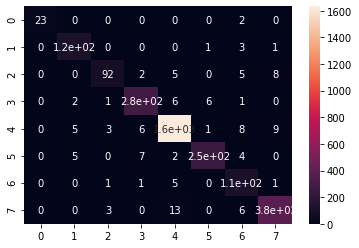

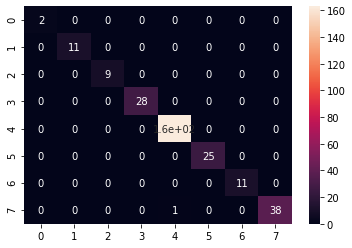

In [43]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.96 0.   0.   0.   0.01 0.02 0.01]
 [0.   0.   0.82 0.02 0.04 0.   0.04 0.07]
 [0.   0.01 0.   0.95 0.02 0.02 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.02 0.   0.03 0.01 0.93 0.01 0.  ]
 [0.   0.   0.01 0.01 0.04 0.   0.93 0.01]
 [0.   0.   0.01 0.   0.03 0.   0.01 0.95]]


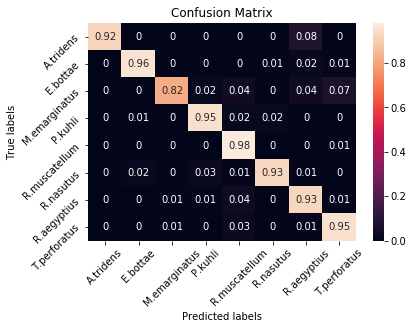

In [44]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)